In [ ]:
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1
  %pip install networkx==2.3

!pip install git+https://github.com/fabriziocosta/EDeN.git

# The code bases on existing models implementation and codes from:
https://github.com/maxuewei2/RiWalk


*   https://github.com/harryjo97/GDSS/tree/e36c1418bf1995b35c6ba49dfc2e4a341d7cff21
*   https://github.com/idea-iitd/graphgen/tree/626ab73a1a4ecf2b2c1863c0f4d63eeee3023240


*   https://github.com/shubhamguptaiitd/GraphRNN/tree/master/graph-label-rnn







# Imports

In [ ]:
from graphs_module import graph_loader, draw_graph
from graph_l_rnn_module import graph_label_rnn_generate
from visual_similarity import vis_sim
from embedding_models import deep_infomax, g_sage, low_dim_transformation, node2Vec_embedding, riwalk_embedding
from graph_stats import graph_statistics
from read_graph import read_graphs_in_networkx

import pandas as pd
import networkx as nx
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity, paired_euclidean_distances, paired_manhattan_distances

from sklearn.metrics.pairwise import pairwise_kernels
from eden.graph import vectorize

from stellargraph.data import BiasedRandomWalk
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
def draw_accuracy_boxplot(data):
  sns.set(style='whitegrid')
  fig, ax = plt.subplots()
  g = sns.boxplot(data=data, width=0.7,notch=True, showcaps=False,
        flierprops={"marker": "o"},
        # boxprops={"facecolor": (.4, .6, .8, .5)},
        medianprops={"color": "coral"}, ax=ax)

  sns.despine(top=True,
                right=True,
                left=True,
                bottom=False)
  plt.tight_layout()

In [ ]:
def generate_graph(g_filename, trained_model_name = "epoch"):
  graph_filename = g_filename
  graph_label_rnn_generate(graph_filename, name = trained_model_name)
  g_graph_nx = graph_loader.load(graph_filename, 100)

  g_graph, g_features_df = graph_loader.transform_to_sg(g_graph_nx)

  infomax = deep_infomax(g_graph)

  infomax.train(verbose=False)

  g_embedding = infomax.embedding(g_graph)
  g_emb_transformed = low_dim_transformation.TSNE(g_embedding, g_graph, g_features_df)

  return g_graph_nx, g_graph, g_features_df, g_embedding, g_emb_transformed

# Utils

In [ ]:
from sklearn.metrics import make_scorer, balanced_accuracy_score, f1_score

def find_estimator(n_estimators = [200, 2000, 10],
                       max_features = ['log2','sqrt'], max_depth = [10, 110, 10],
                       min_samples_split = [2, 6, 10],
                       min_samples_leaf = [1, 3, 4], bootstrap = [True, False], 
                       n_iter = 100, cv = 5, rnd_state = 404, balance = True):
      
  # Number of trees in random forest
  n_estimators = [int(x) for x in np.linspace(start = n_estimators[0], stop = n_estimators[1],
                                                  num = n_estimators[2])]

  # Maximum number of levels in tree
  max_depth = [int(x) for x in np.linspace(max_depth[0], max_depth[1], num = max_depth[2])]
  max_depth.append(None)

  # Create the random grid
  random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

  if balance:
    random_grid['class_weight'] = ['balanced']
      
  forest = RandomForestClassifier()
  return RandomizedSearchCV(estimator = forest, param_distributions = random_grid, scoring = make_scorer(f1_score, average = 'weighted'),
                                      n_iter = 100, cv = 5, verbose=2, random_state=404, n_jobs = -6)

In [ ]:
from imblearn.over_sampling import SMOTE
def SMOTE_transform(X, y):
  oversample = SMOTE()
  return oversample.fit_resample(X, y)


In [ ]:
def replace_category(node_y):
  cat_frq = pd.DataFrame(node_y).value_counts()
  replacement = cat_frq.keys()[0][0]
  cats_to_replace = [i[0][0] for i in dict(cat_frq).items() if i[1] == 1]

  node_y = pd.DataFrame(node_y).replace(cats_to_replace, replacement)

  return np.array(node_y).reshape(-1)

In [ ]:
def count_weights(labels):
  val, counts = np.unique(labels, return_counts=True)
  weighted_labels = dict(zip(val,counts))
  print(weighted_labels)
  for label in weighted_labels:
    weighted_labels[label] = (1/(weighted_labels[label]/len(labels)))


  print(weighted_labels)
  return  weighted_labels

In [ ]:
def class_test_labeled_rnn(n_iter, train_on_orig = False, orig_fname = "data/citation.txt", graph_fname = "generate_experiment_labeled_rnn/citation/graph", batch_size= 100, trained_model_name = "epoch", model_params = None, riwalk = False, SMOTE= False, balance = False):
  if train_on_orig:
    d_type = "synthetic"
  else:
    d_type = "original"
  orig_filename = orig_fname
  graph_filename = graph_fname
  best_params = model_params
  accuracy_score_test = list()
  accuracy_score_origin = list()
  for i in range(n_iter):
    #load orig graph
    orig_graph_nx = graph_loader.load(orig_filename, batch_size, random_sampling = True)
    if not riwalk:
      orig_graph, orig_labels = graph_loader.transform_to_sg(orig_graph_nx)
    
    #generate graph
    graph_label_rnn_generate(graph_filename + "_" + str(i), name = trained_model_name)
    
    g_graph_nx = graph_loader.load(graph_filename + "_" + str(i), batch_size)
    if not riwalk:
      g_graph, g_labels = graph_loader.transform_to_sg(g_graph_nx)

    #embedding
    if riwalk:
      g_labels = [n[1]['node_label'] for n in g_graph_nx.nodes.data()]

      orig_labels = [n[1]['node_label'] for n in orig_graph_nx.nodes.data()]
      
      g_embedding, g_targets = riwalk_embedding(g_graph_nx, g_labels)

      orig_embedding, orig_targets = riwalk_embedding(orig_graph_nx, orig_labels)
    else:
      g_embedding, g_targets = node2Vec_embedding(g_graph, g_labels)
   
      orig_embedding, orig_targets = node2Vec_embedding(orig_graph, orig_labels)
    
    #train/test split

    synth_node_y = replace_category(g_targets)

    orig_node_y = replace_category(orig_targets)

    if train_on_orig:

      X_train, X_test, y_train, y_test = train_test_split( 
            orig_embedding, orig_node_y, train_size=0.75, test_size=0.25, shuffle=True, stratify = orig_node_y)
    else :

        X_train, X_test, y_train, y_test = train_test_split( 
              g_embedding, synth_node_y, train_size=0.75, test_size=0.25, shuffle=True, stratify = synth_node_y)
    


    if best_params is None:
      rnd_search = find_estimator(balance = balance)
      if SMOTE:
        val, counts = np.unique(y_train,return_counts=True)

        sm_x, sm_y = SMOTE_transform(X_train, y_train)
        val, counts = np.unique(sm_y,return_counts=True)

        rnd_search.fit(sm_x, sm_y)
      else:
        rnd_search.fit(X_train, y_train)
      best_params = rnd_search.best_params_

    model = RandomForestClassifier(**best_params)
    model.set_params(class_weight = count_weights(y_train))

    if SMOTE:
      sm_x, sm_y = SMOTE_transform(X_train, y_train)
      val, counts = np.unique(sm_y,return_counts=True)
      # print(dict(zip(val, counts)))
      model.fit(sm_x, sm_y)
    else:
      model.fit(X_train, y_train)

    # test data
    y_pred =  model.predict(X_test)

    accuracy_score_test.append(f1_score(y_pred, y_test, average='macro'))

    #orig data
    if train_on_orig:
      y_pred =  model.predict(g_embedding)

      accuracy_score_origin.append(f1_score(y_pred, synth_node_y, average='macro'))

    else:
      y_pred =  model.predict(orig_embedding)

      accuracy_score_origin.append(f1_score(y_pred, orig_node_y, average='macro'))

  return best_params, pd.DataFrame({"f1 score on test dataset" : accuracy_score_test,
                            "f1 score on {} dataset".format(d_type): accuracy_score_origin})

In [ ]:
def class_test(n_iter, train_on_orig = False, orig_fname = '/content/drive/MyDrive/Github/GDSS/QM9_graphs/graph',
                        graph_fname = '/content/drive/MyDrive/Github/GDSS/logs_sample/QM9/test/graph',
                        dataset = "citeseer", orig_g_count = 13000, synt_g_count = 3000, batch_size = 100, label_name = 'label', ed_label = 'label', cut_label = False, model_params=None, riwalk = False, SMOTE= False, balance = False):
  if train_on_orig:
    d_type = "synthetic"
  else:
    d_type = "original"
  orig_filename = orig_fname
  graph_filename = graph_fname
  best_params = model_params
  accuracy_score_test = list()
  accuracy_score_origin = list()
  for i in range(n_iter):
    
    #load orig graph
    orig_graph_nx = graph_loader.load_pickle(orig_filename, orig_g_count, batch_size, True, dataset, label_name, ed_label, cut_label )
    if not riwalk:
      orig_graph, orig_labels = graph_loader.transform_to_sg(orig_graph_nx, 'topic')
    # orig_graph, orig_labels = graph_loader.transform_to_sg(orig_graph_nx,'topic')

    #load synth graph
    
    g_graph_nx = graph_loader.load_pickle(graph_filename, synt_g_count, batch_size, True, dataset, label_name, ed_label, cut_label)
    if not riwalk:
      g_graph, g_labels = graph_loader.transform_to_sg(g_graph_nx, 'topic')
    # g_graph, g_labels = graph_loader.transform_to_sg(g_graph_nx)

    #embedding
    if riwalk:
      g_labels = [n[1]['topic'] for n in g_graph_nx.nodes.data()]

      orig_labels = [n[1]['topic'] for n in orig_graph_nx.nodes.data()]
      
      g_embedding, g_targets = riwalk_embedding(g_graph_nx, g_labels)

      orig_embedding, orig_targets = riwalk_embedding(orig_graph_nx, orig_labels)
    else:
      g_embedding, g_targets = node2Vec_embedding(g_graph, g_labels)
   
      orig_embedding, orig_targets = node2Vec_embedding(orig_graph, orig_labels)

    #train/test split

    synth_node_y = replace_category(g_targets)

    orig_node_y = replace_category(orig_targets)

    if train_on_orig:
      X_train, X_test, y_train, y_test = train_test_split( 
            orig_embedding, orig_node_y, train_size=0.75, test_size=0.25, shuffle=True, stratify = orig_node_y)
    else :

      X_train, X_test, y_train, y_test = train_test_split( 
              g_embedding, synth_node_y, train_size=0.75, test_size=0.25, shuffle=True, stratify = synth_node_y)



    if best_params is None:
      rnd_search = find_estimator(balance= balance)

      if SMOTE:
        val, counts = np.unique(y_train,return_counts=True)

        sm_x, sm_y = SMOTE_transform(X_train, y_train)
        val, counts = np.unique(sm_y,return_counts=True)

        rnd_search.fit(sm_x, sm_y)
      else:
        rnd_search.fit(X_train, y_train)
      best_params = rnd_search.best_params_

    model = RandomForestClassifier(**best_params)
    model.set_params(class_weight = count_weights(y_train))
    #train class
    if SMOTE:
      sm_x, sm_y = SMOTE_transform(X_train, y_train)
      val, counts = np.unique(sm_y,return_counts=True)

      model.fit(sm_x, sm_y)
    else:
      model.fit(X_train, y_train)
    # test data
    y_pred =  model.predict(X_test)

    test_pred_y = y_pred
    accuracy_score_test.append(f1_score(y_pred, y_test, average='macro'))
    #orig data
    if train_on_orig:
      y_pred =  model.predict(g_embedding)

      accuracy_score_origin.append(f1_score(y_pred, synth_node_y, average='macro'))
    else:
      y_pred =  model.predict(orig_embedding)

      accuracy_score_origin.append(f1_score(y_pred, orig_node_y, average='macro'))

  return  best_params, pd.DataFrame({"f1 score on test dataset" : accuracy_score_test,
                            "f1 score on {} dataset".format(d_type): accuracy_score_origin})

# Labeled Graph RNN

# Citation dataset

---



## Statistical tests

In [ ]:
orig_filename = "data/citation.txt"
graphs_folder = "generate_experiment_labeled_rnn/citation"

stat_tests = graph_statistics(generate_graph, orig_filename, graphs_folder)

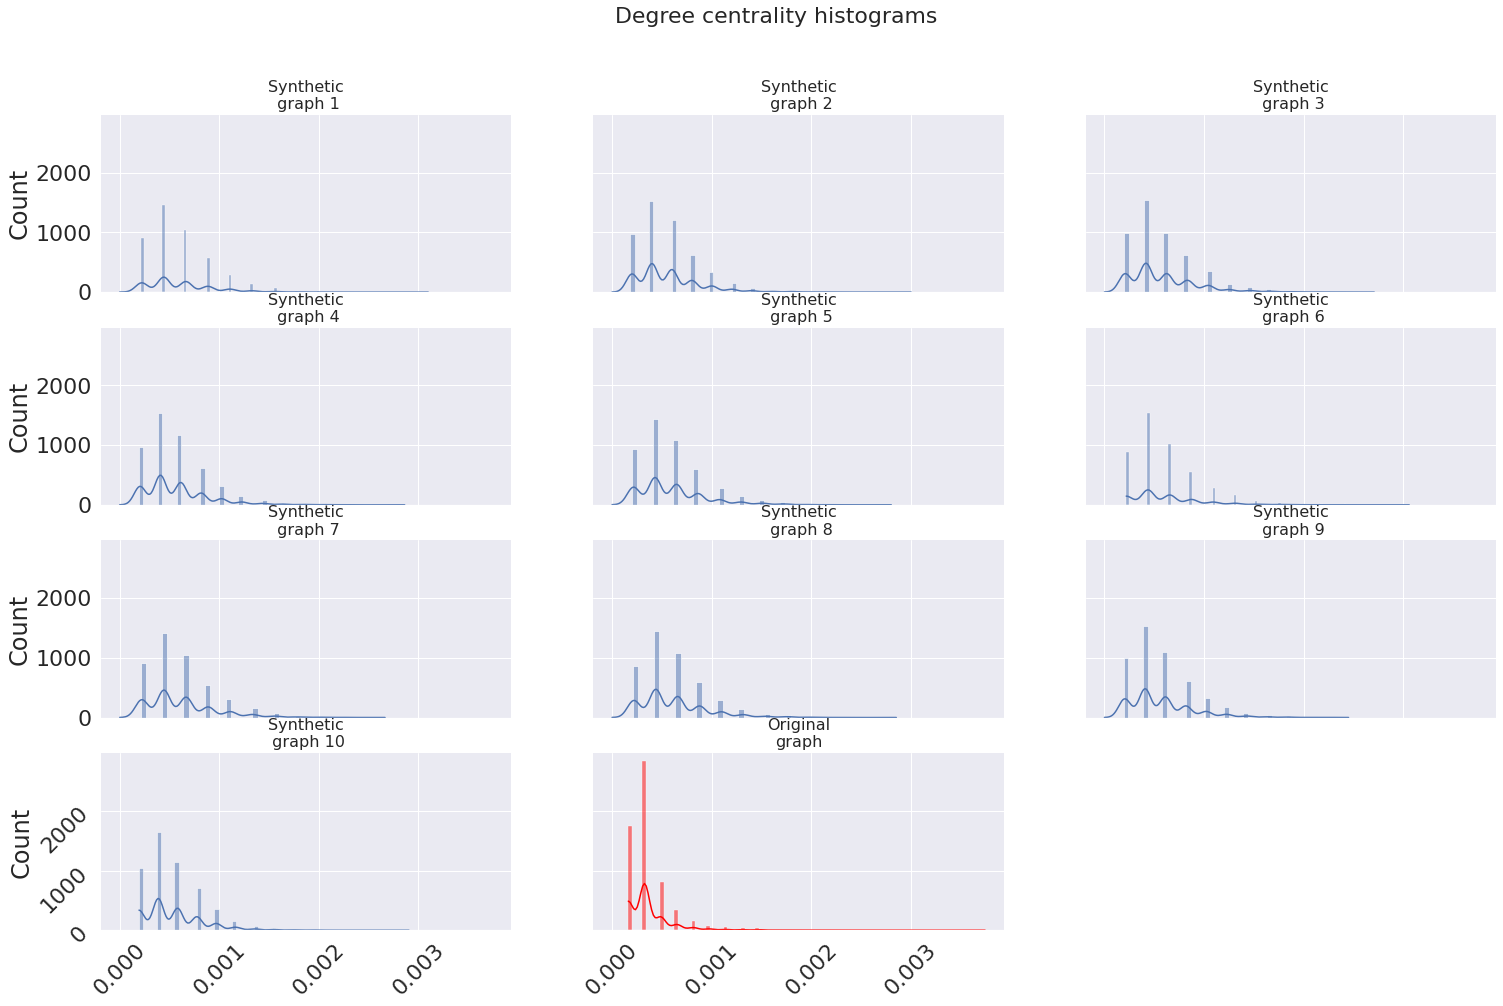

In [ ]:
stat_tests.degree_centrality_hist()

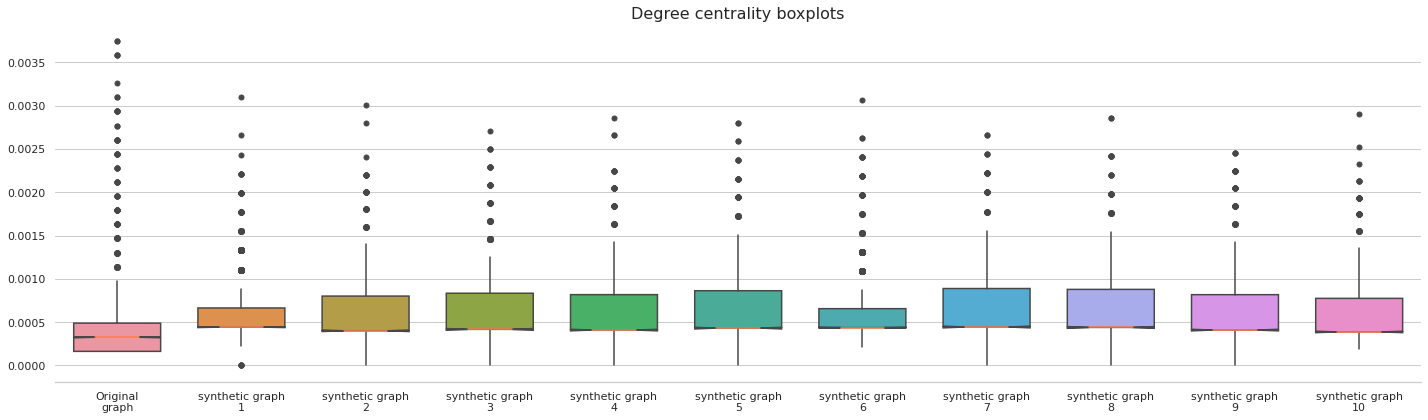

In [ ]:
stat_tests.degree_centrality_boxplot()

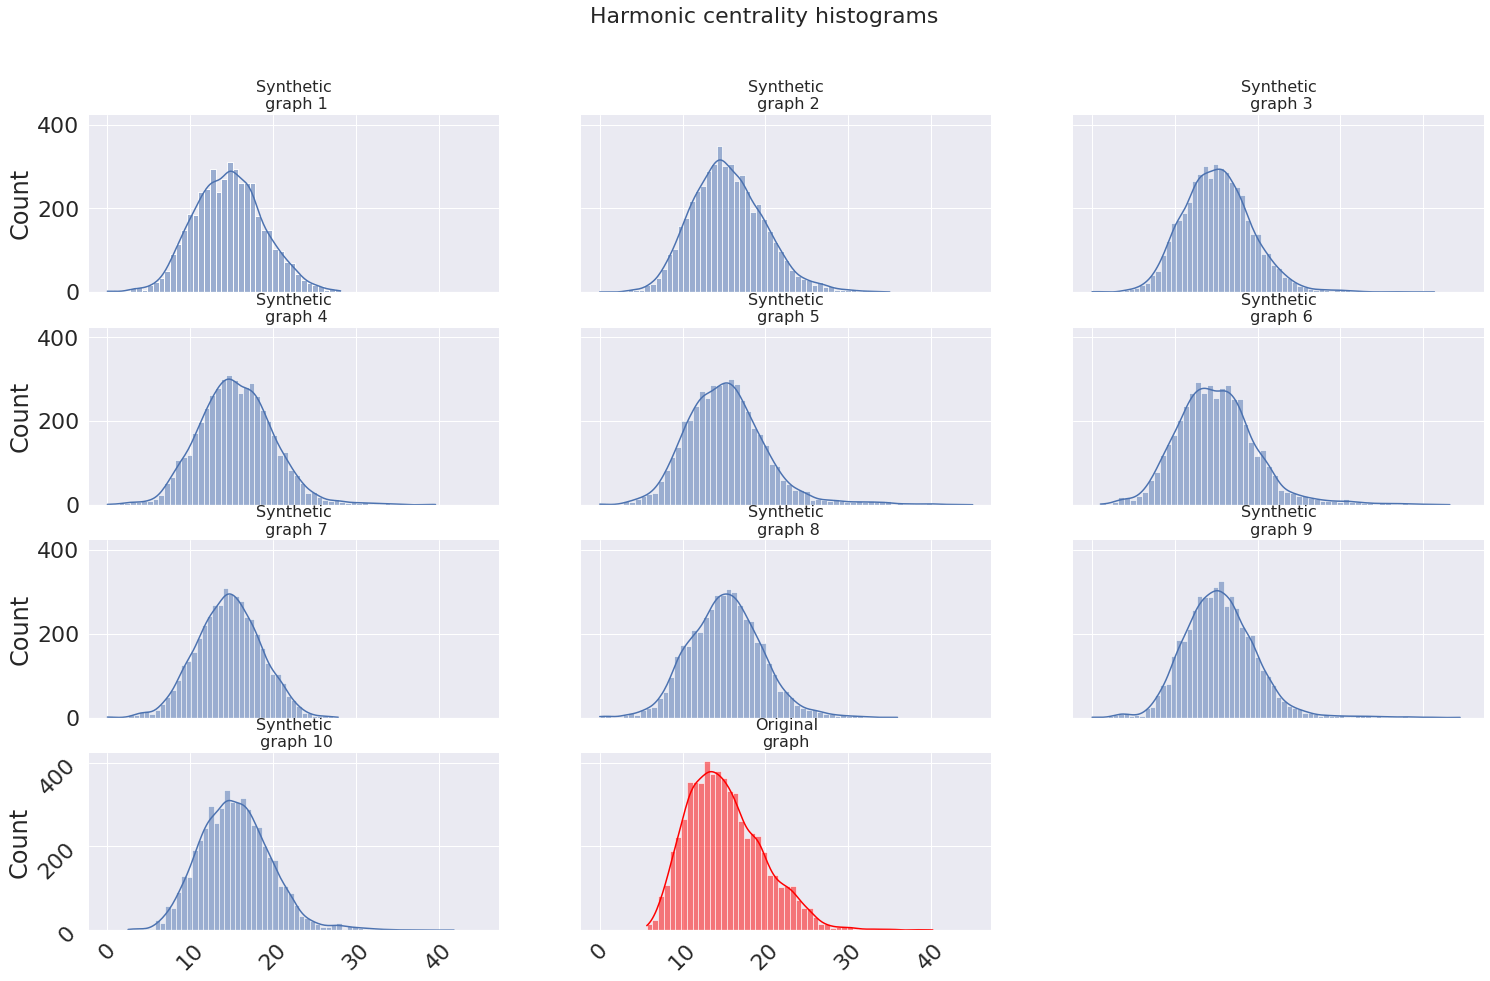

In [ ]:
stat_tests.harmonic_centrality_hist()

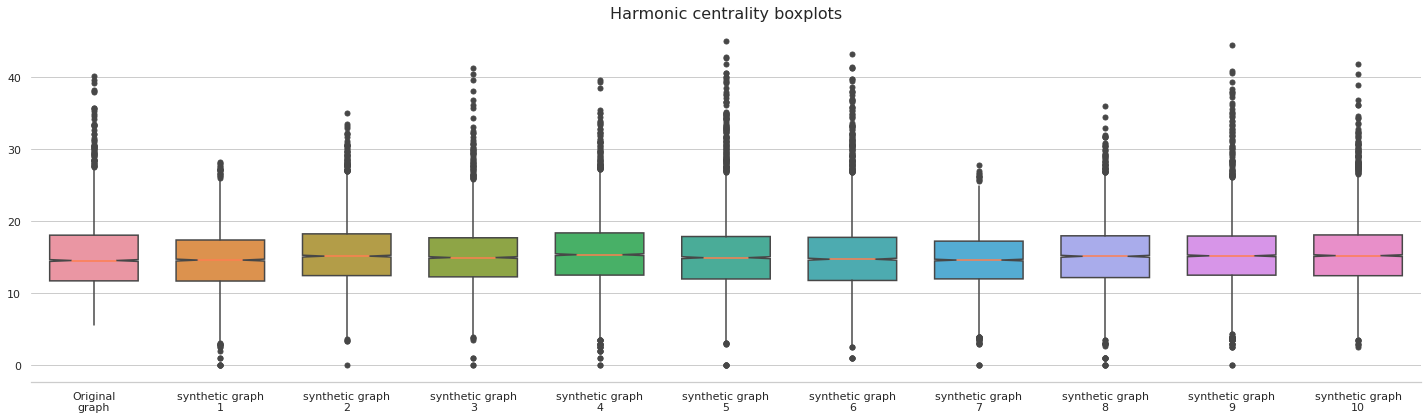

In [ ]:
stat_tests.harmonic_centrality_boxplot()

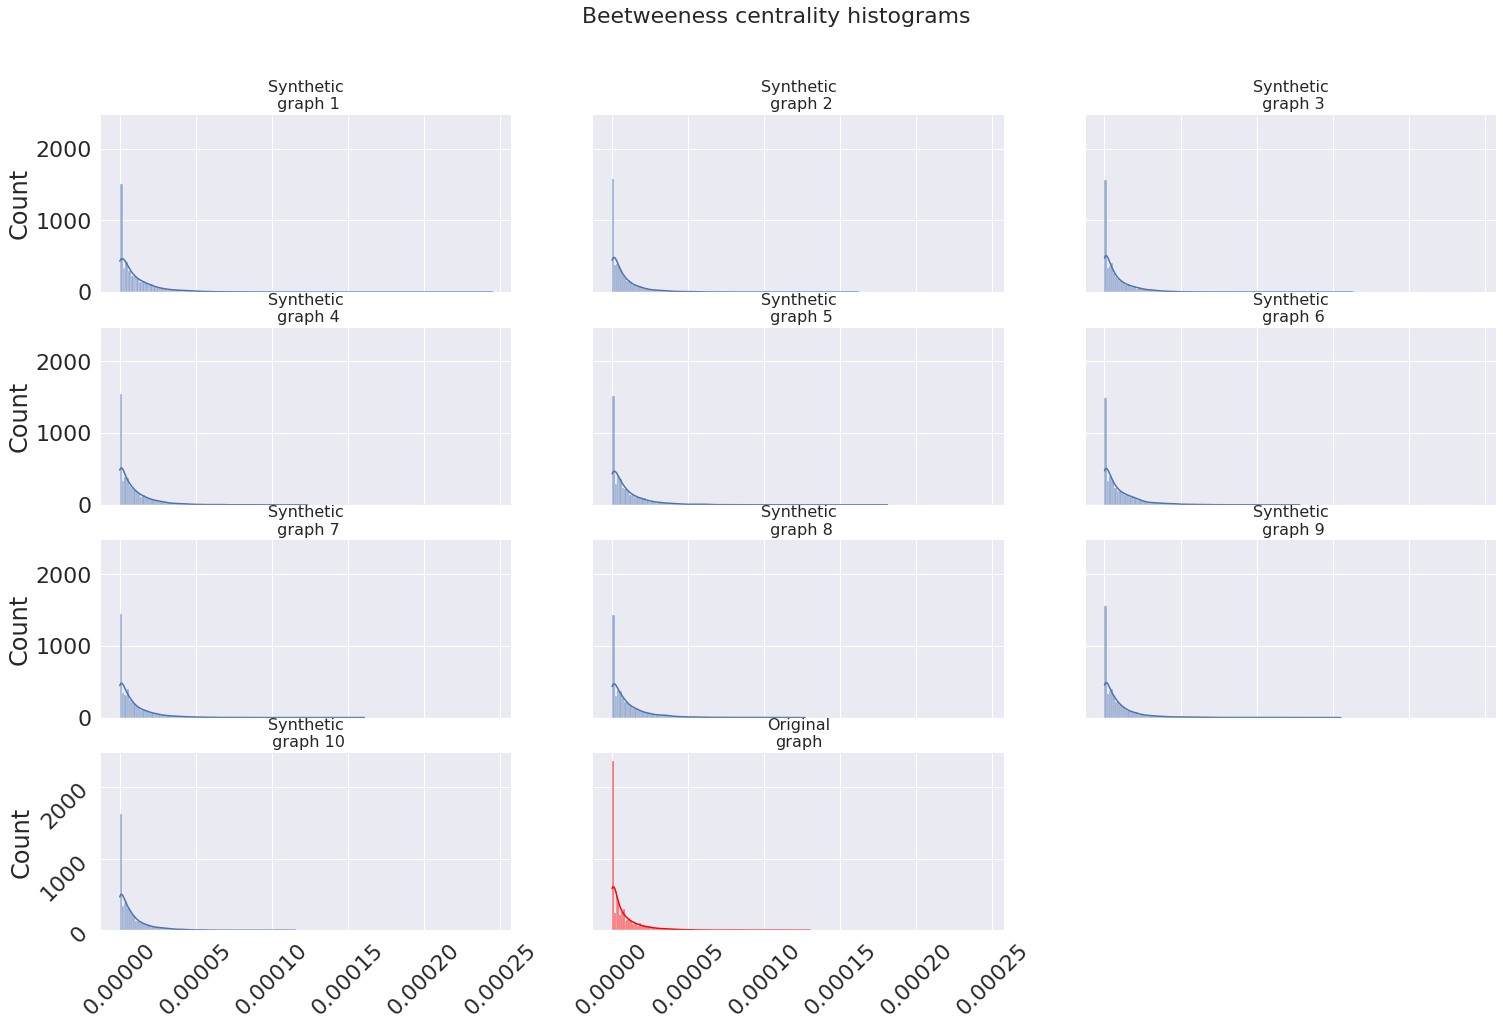

In [ ]:
stat_tests.beetweenness_centrality_hist()

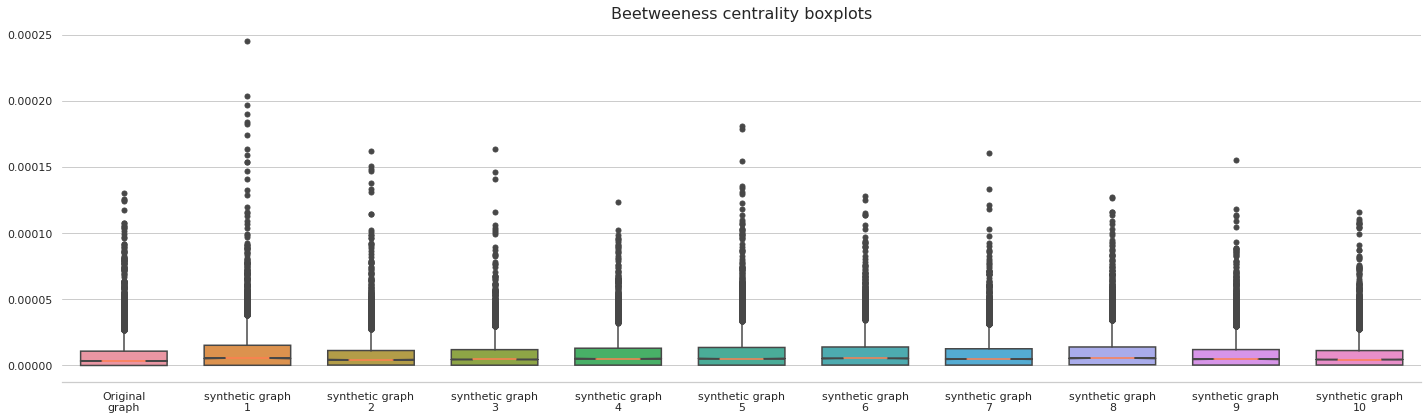

In [ ]:
stat_tests.beetweenness_centrality_boxplot()

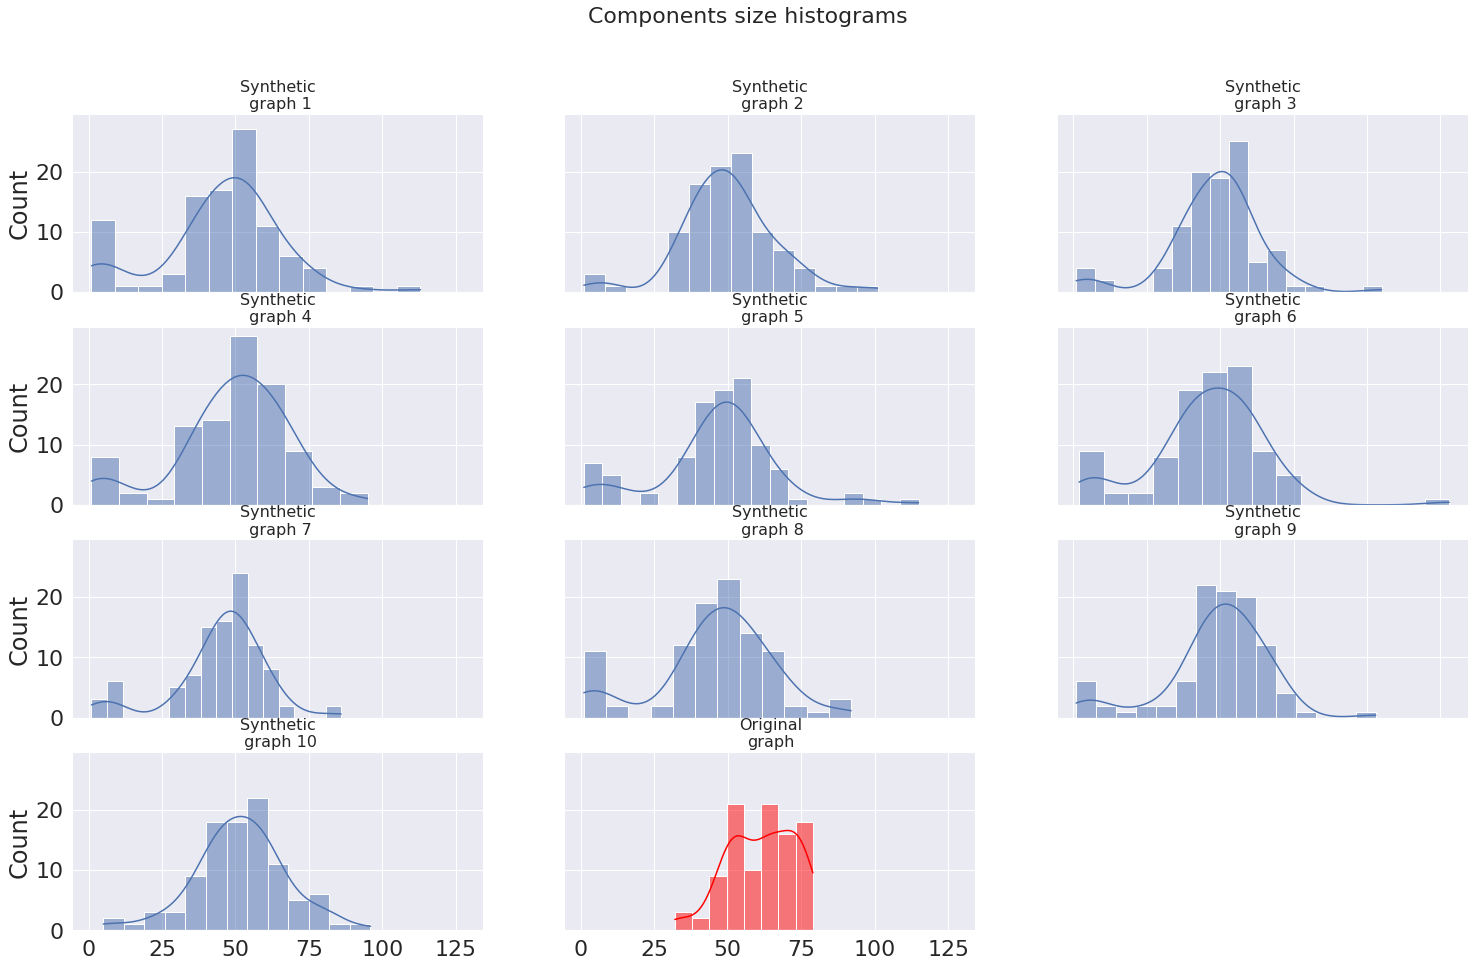

In [ ]:
stat_tests.components_sizes_hist()

## Visual similarity tests

In [ ]:
orig_filename = "data/citation.txt"
graphs_folder = "generate_experiment_labeled_rnn/citation"
sim_test = vis_sim(orig_filename = orig_filename, graph_filename = graphs_folder,
                   emb_model = "riwalk", scale = False, dataset=None, load_synt= False)

In [ ]:
sim_test.measure_similarity()

In [ ]:
sim_test.draw_sim_graphs(15, metric = "euc")

## Classification tests

In [ ]:
params_rnn_cit_synth = {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 76, 'class_weight': 'balanced', 'bootstrap': False}
orig_graphs_folder= "data/citation.txt"
synt_graphs_folder = "generate_experiment_labeled_rnn/citation"
params_rnn_cit_synth, label_rnn_citation_synth = class_test_labeled_rnn(30, False, orig_graphs_folder, synt_graphs_folder, model_params = params_rnn_cit_synth, riwalk = True, SMOTE= False, balance = True)

In [ ]:
print(params_rnn_cit_synth)

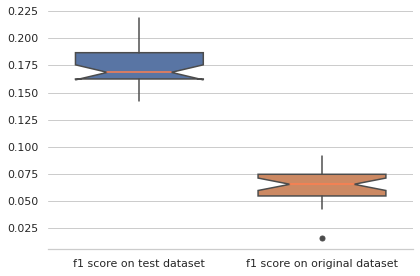

In [ ]:
draw_accuracy_boxplot(label_rnn_citation_synth)

In [ ]:
params_rnn_cit_orig,label_rnn_citation_orig = class_test_labeled_rnn(10, train_on_orig = True, model_params = params_rnn_cit_synth, riwalk = True, SMOTE= False, balance = True) 

In [ ]:
print(params_rnn_cit_orig)

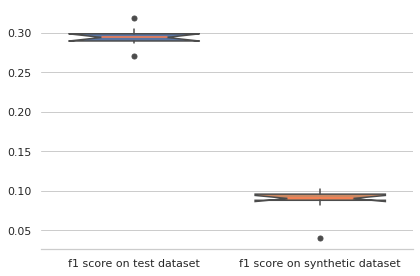

In [ ]:
draw_accuracy_boxplot(label_rnn_citation_orig)

# Yeast Dataset

---



## Statistical tests

In [ ]:
orig_filename = "data/yeast.txt"
graphs_folder = "generate_experiment_labeled_rnn/yeast"

stat_tests = graph_statistics(generate_graph, orig_filename, graphs_folder, model_name='yeast')

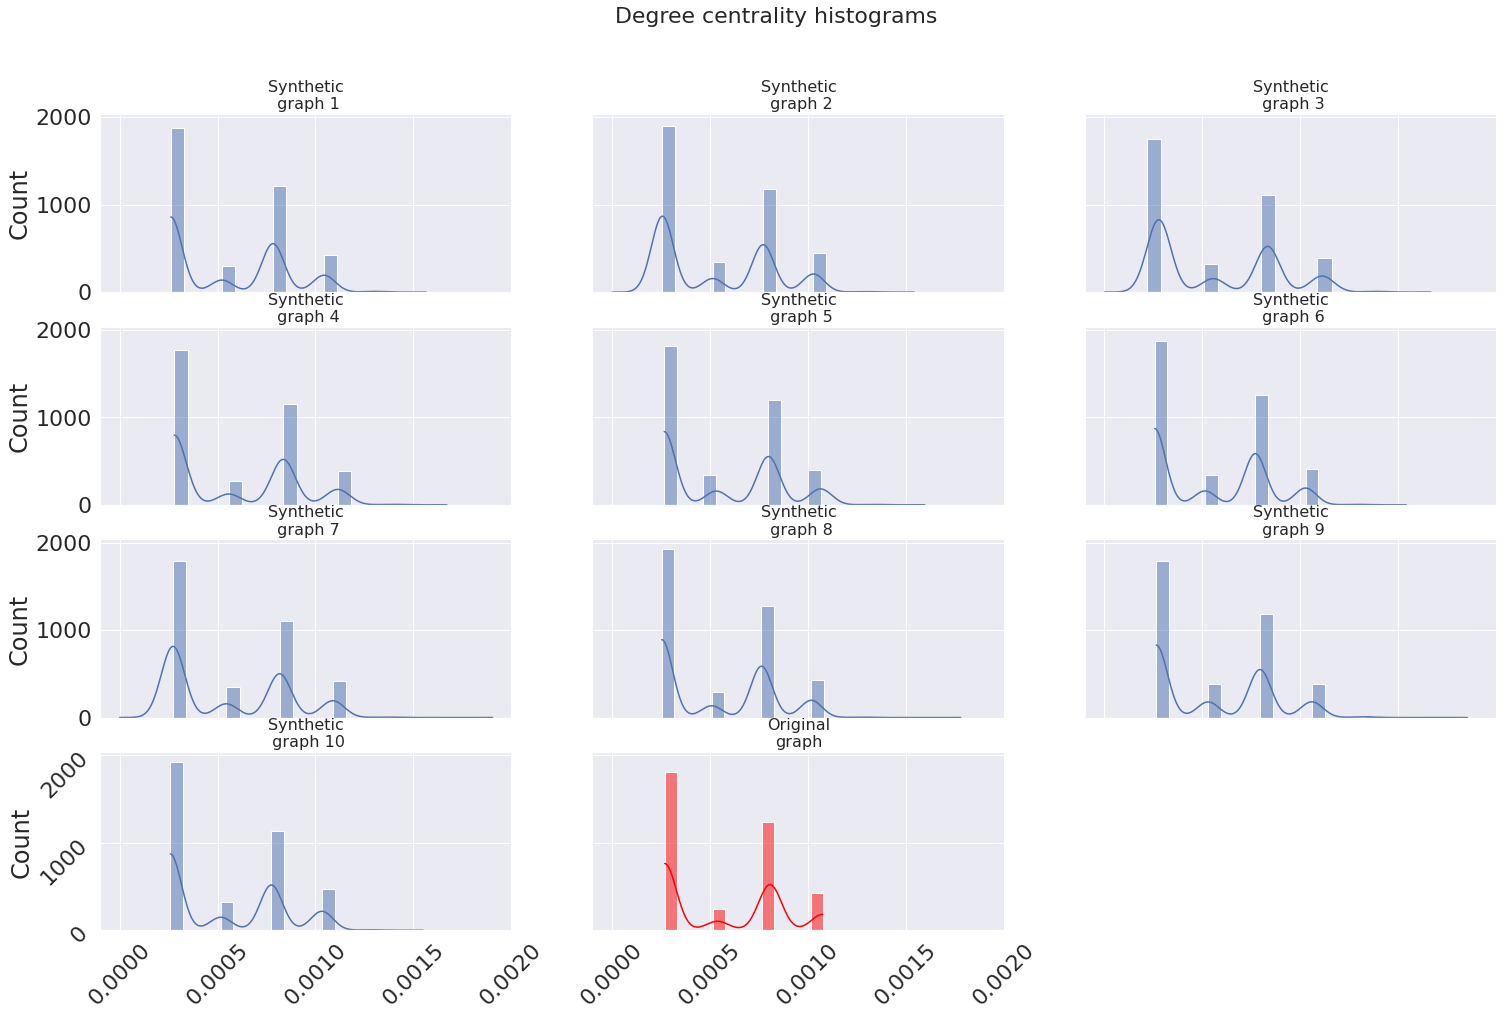

In [ ]:
stat_tests.degree_centrality_hist()

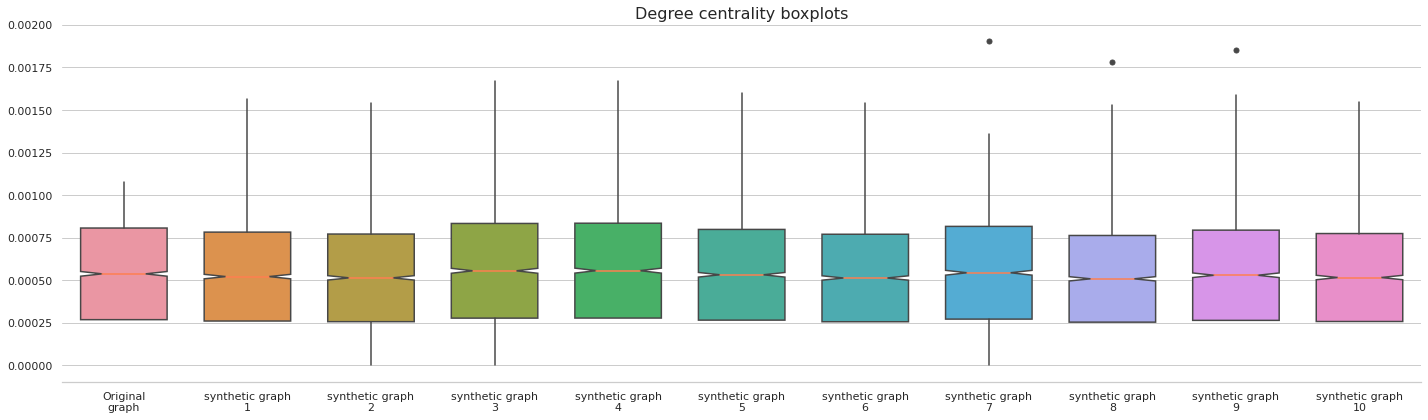

In [ ]:
stat_tests.degree_centrality_boxplot()

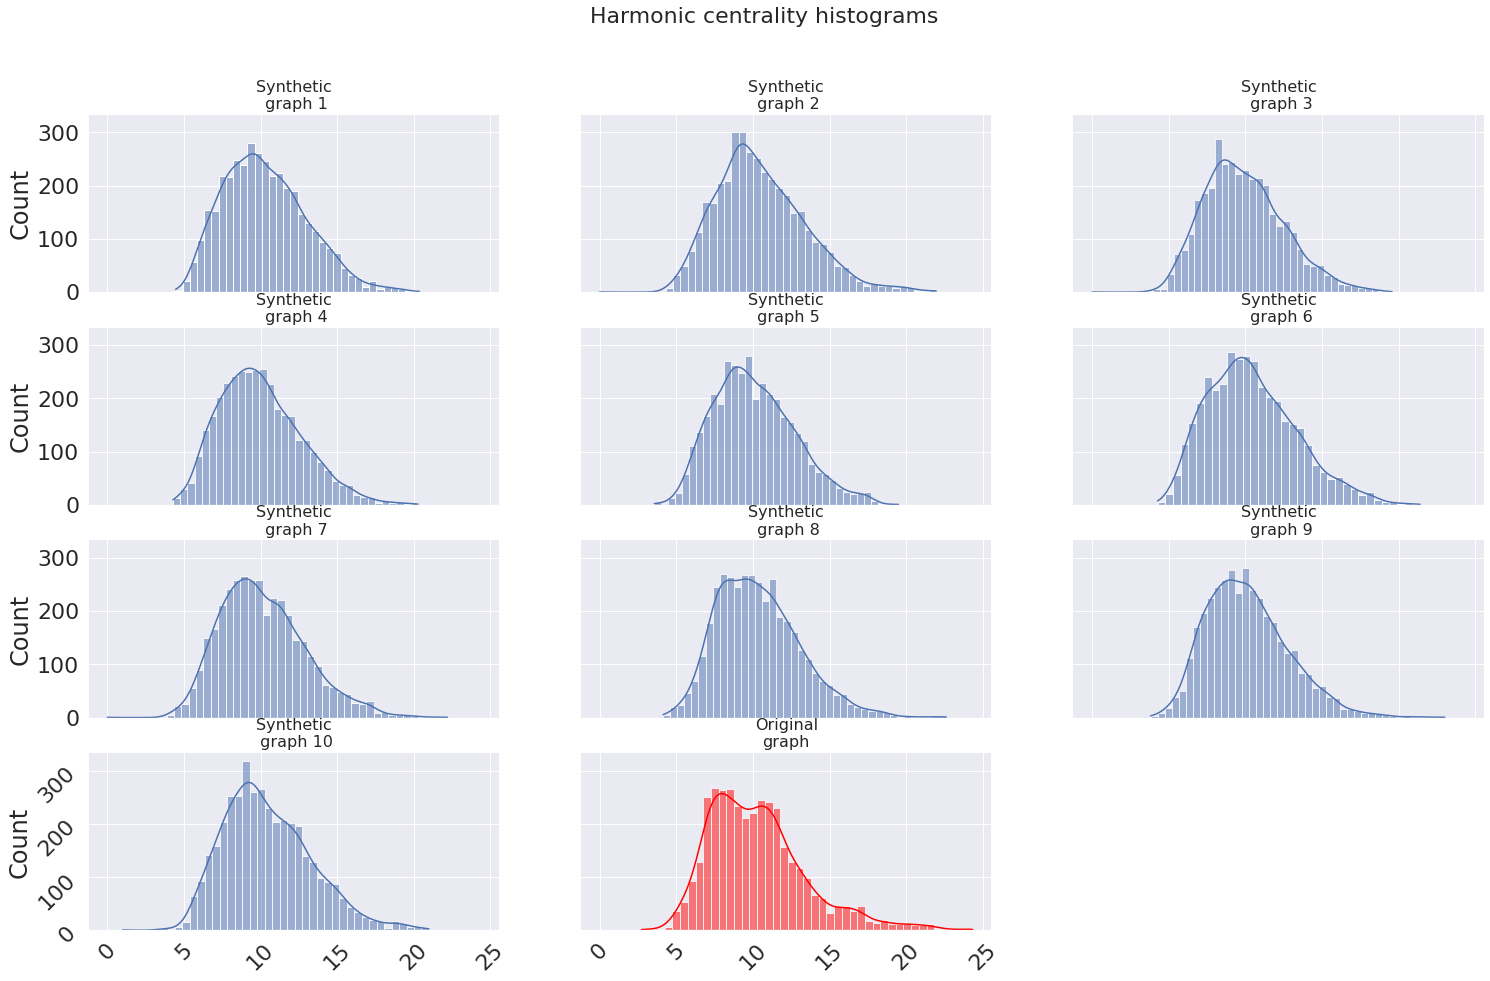

In [ ]:
stat_tests.harmonic_centrality_hist()

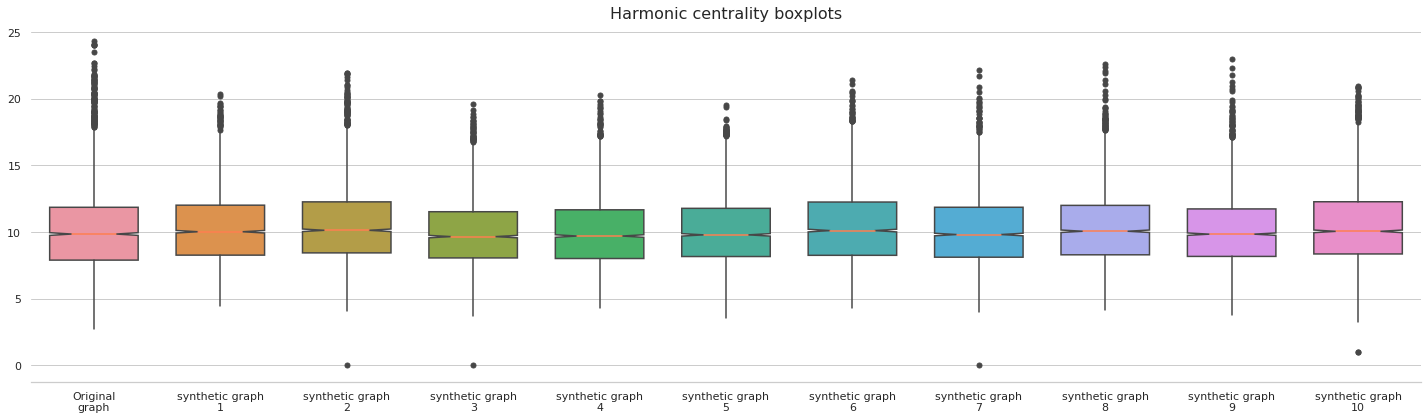

In [ ]:
stat_tests.harmonic_centrality_boxplot()

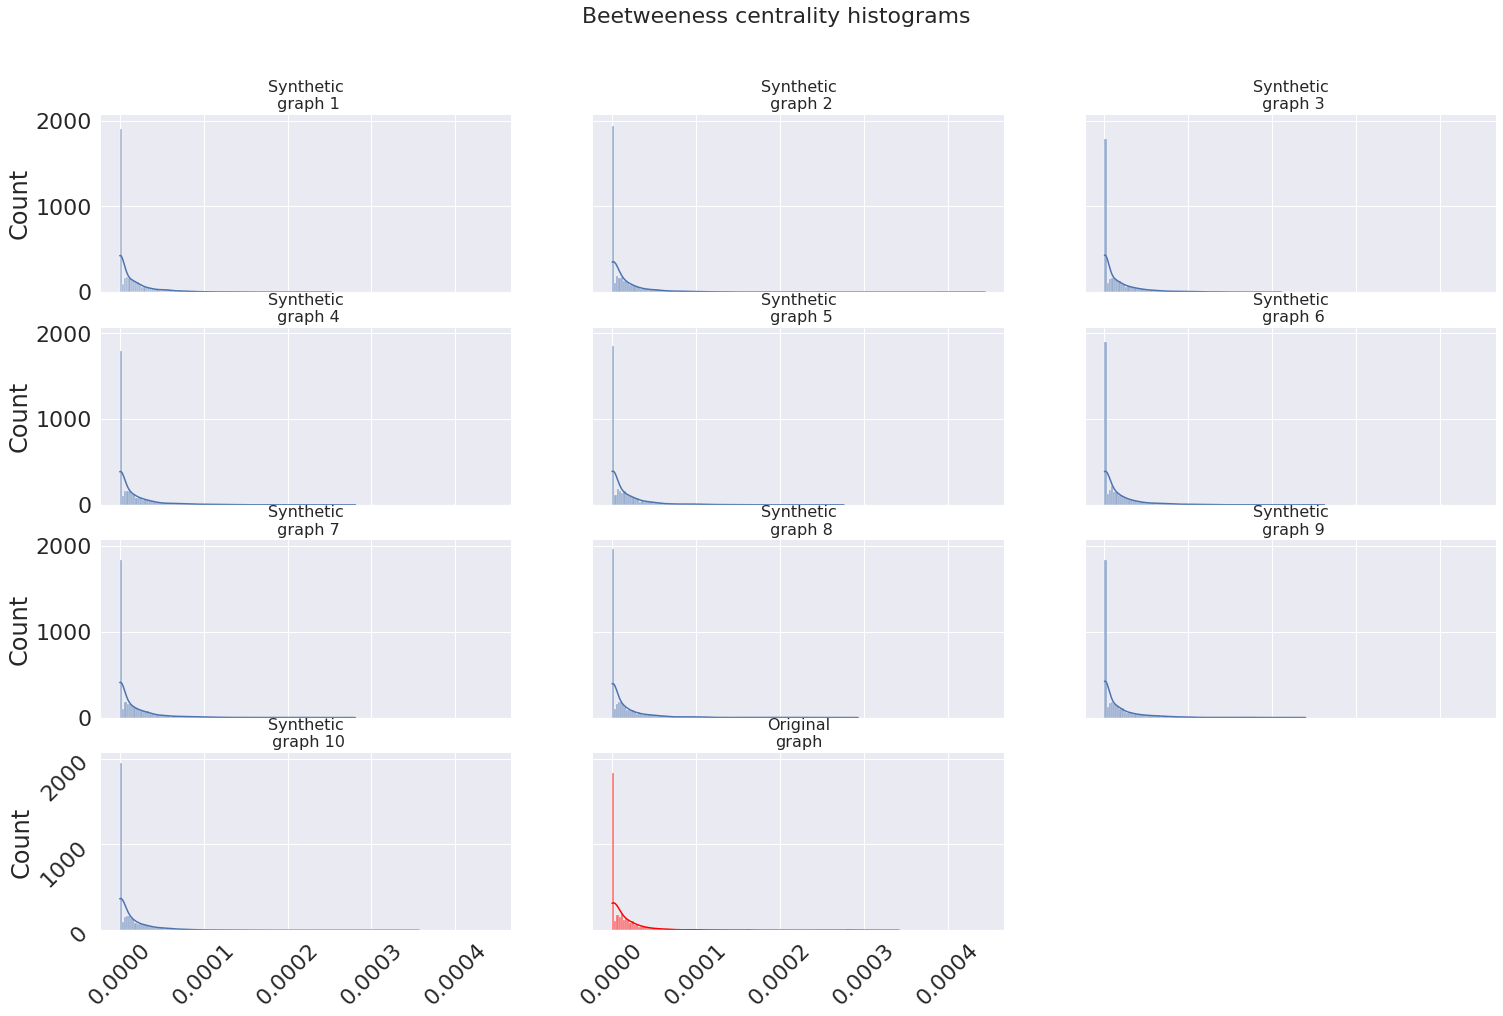

In [ ]:
stat_tests.beetweenness_centrality_hist()

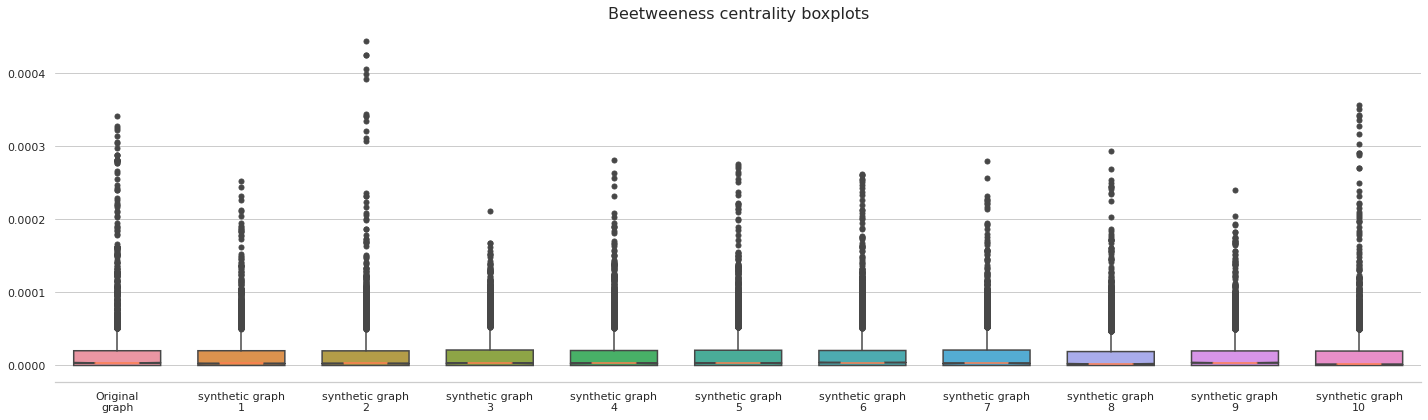

In [ ]:
stat_tests.beetweenness_centrality_boxplot()

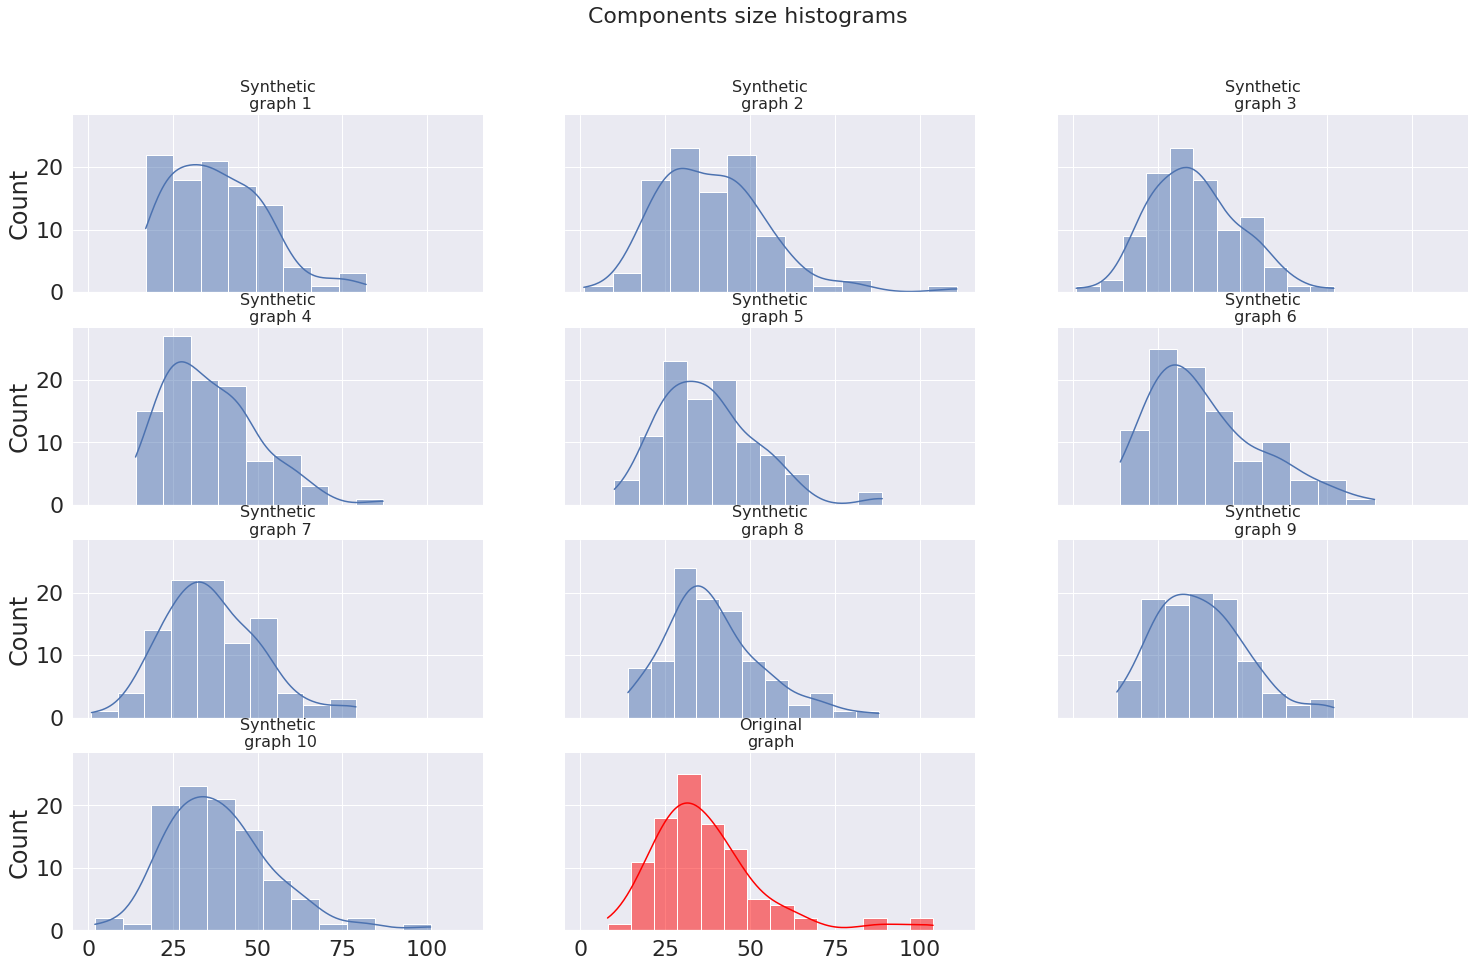

In [ ]:
stat_tests.components_sizes_hist()

## Visual similarity tests

In [ ]:
orig_filename = "data/yeast.txt"
graphs_folder = "generate_experiment_labeled_rnn/yeast"
sim_test = vis_sim(orig_filename = orig_filename, graph_filename = graphs_folder, trained_model_name = "yeast",
                   emb_model = "riwalk", scale = False, dataset=None, load_synt= False)

In [ ]:
sim_test.measure_similarity()

In [ ]:
sim_test.draw_sim_graphs(15, metric = "euc")

## Classification tests

In [ ]:
orig_graphs_folder = "/content/drive/MyDrive/Github/GraphRNN/graph-label-rnn/data/yeast.txt"
synt_graphs_folder = "/content/drive/MyDrive/Github/GraphRNN/graph-label-rnn/generate_experiment_labeled_rnn/yeast/graph"
params_rnn_yeast_synt = {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 32, 'class_weight': 'balanced', 'bootstrap': True}
params_rnn_yeast_synt, label_rnn_yeast_synth = class_test_labeled_rnn(30, False, orig_graphs_folder, synt_graphs_folder, trained_model_name = "yeast", model_params = params_rnn_yeast_synt, riwalk = True, SMOTE= False, balance = True) 

In [ ]:
print(params_rnn_yeast_synt)

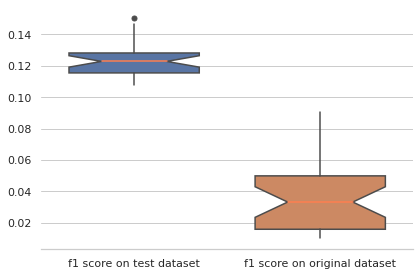

In [ ]:
draw_accuracy_boxplot(label_rnn_yeast_synth)

In [ ]:
params_rnn_yeast_orig, label_rnn_yeast_orig = class_test_labeled_rnn(10, True, orig_graphs_folder, synt_graphs_folder, trained_model_name = "yeast", model_params = params_rnn_yeast_synt, riwalk = True, SMOTE= False, balance = True ) 

In [ ]:
print(params_rnn_yeast_orig)

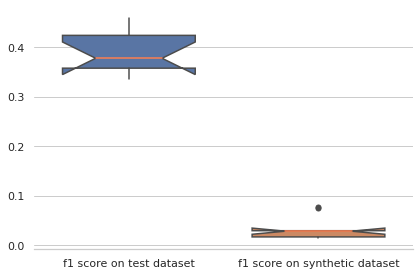

In [ ]:
draw_accuracy_boxplot(label_rnn_yeast_orig)

# GraphGen

# Citeseer dataset

---

## Statistical tests

In [ ]:
orig_filename = "/content/drive/MyDrive/Github/graphgen/datasets/citeseer/graphs/graph"
graphs_folder = "/content/drive/MyDrive/Github/graphgen/graphs/DFScodeRNN_citeseer_2022-12-21 14:32:51/5/graph"

stat_tests = graph_statistics(None, orig_filename, graphs_folder, another_load_method = True)

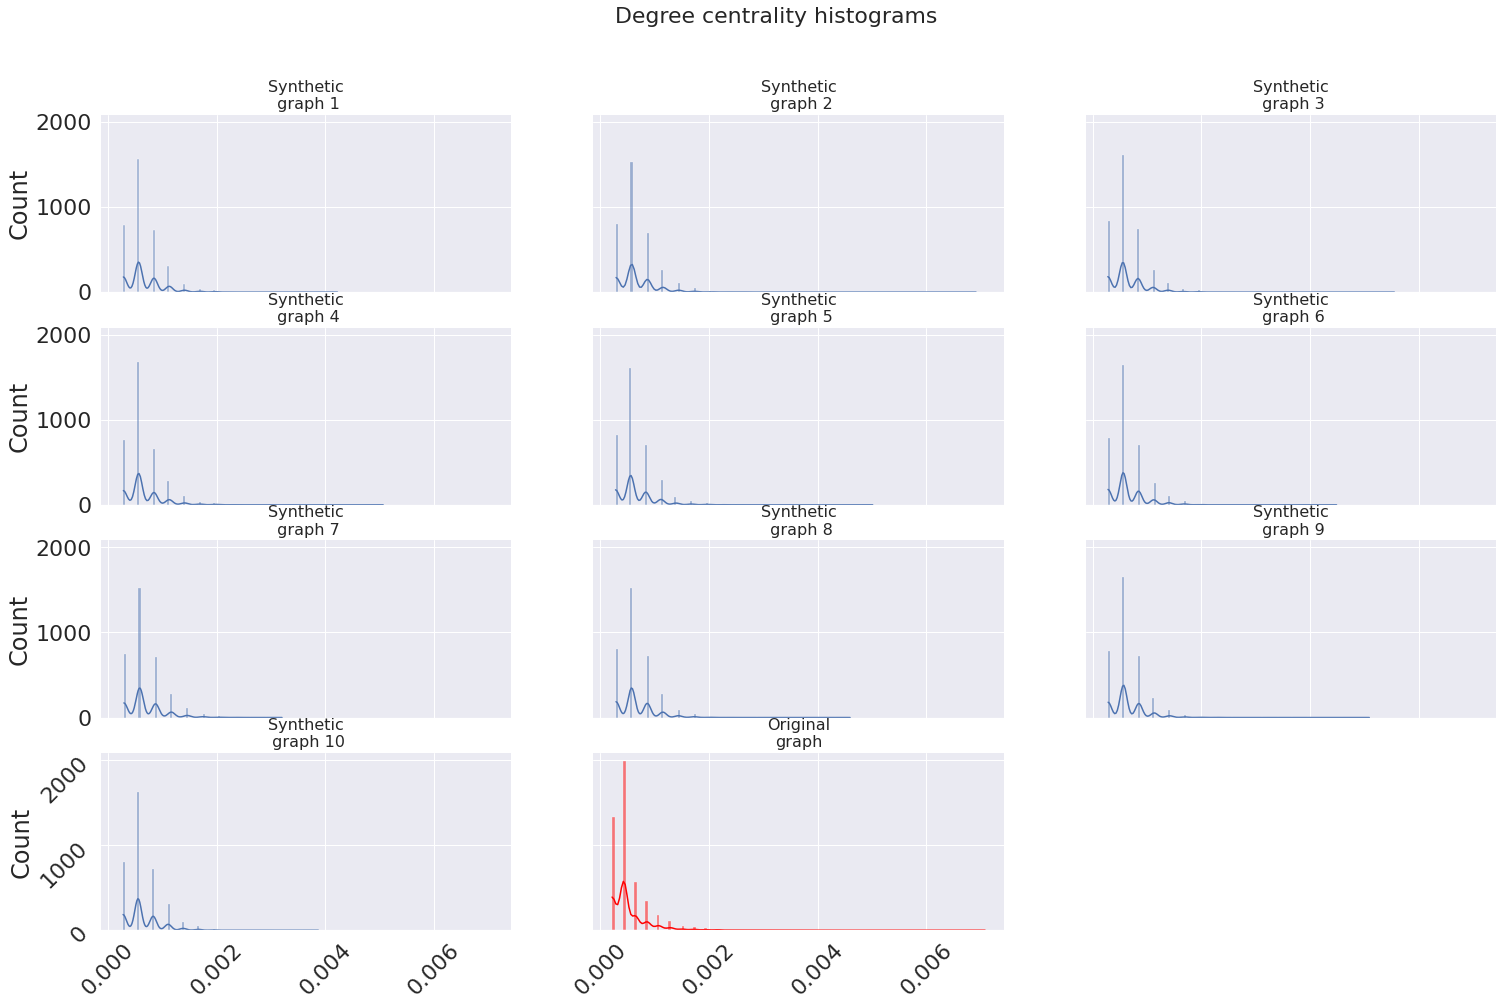

In [ ]:
stat_tests.degree_centrality_hist()

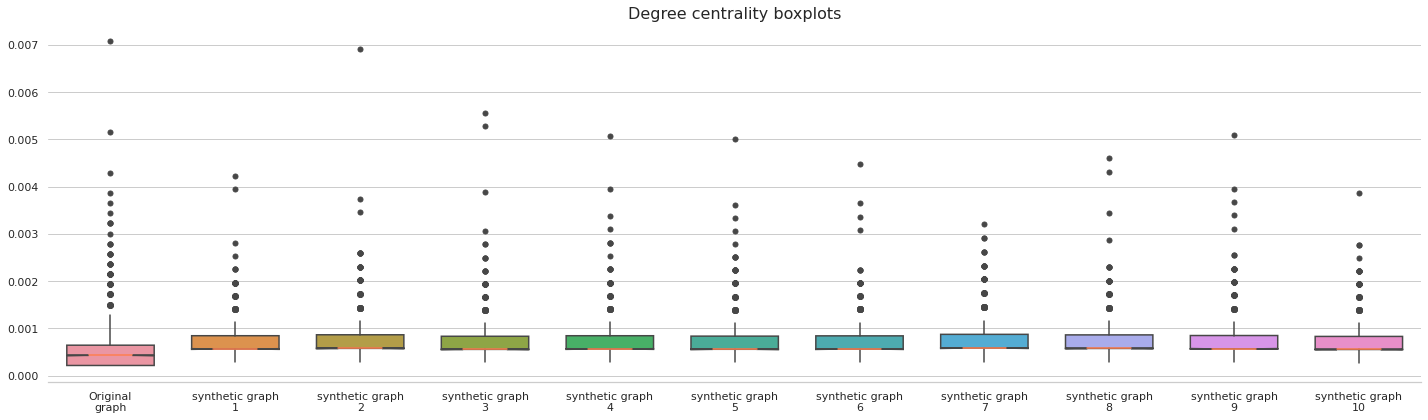

In [ ]:
stat_tests.degree_centrality_boxplot()

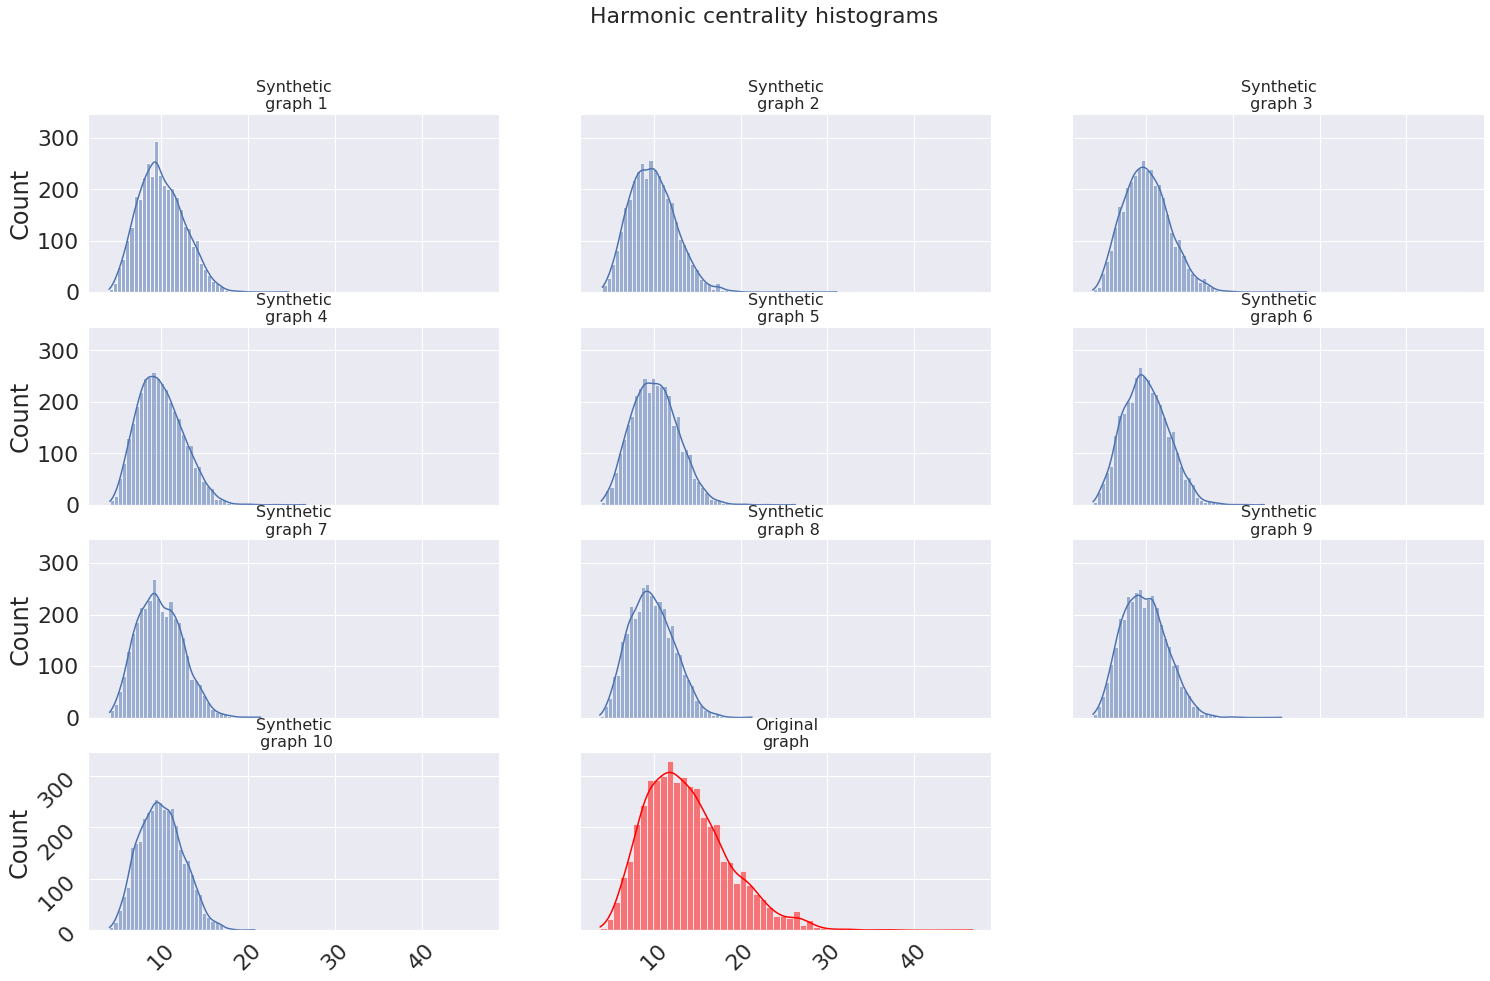

In [ ]:
stat_tests.harmonic_centrality_hist()

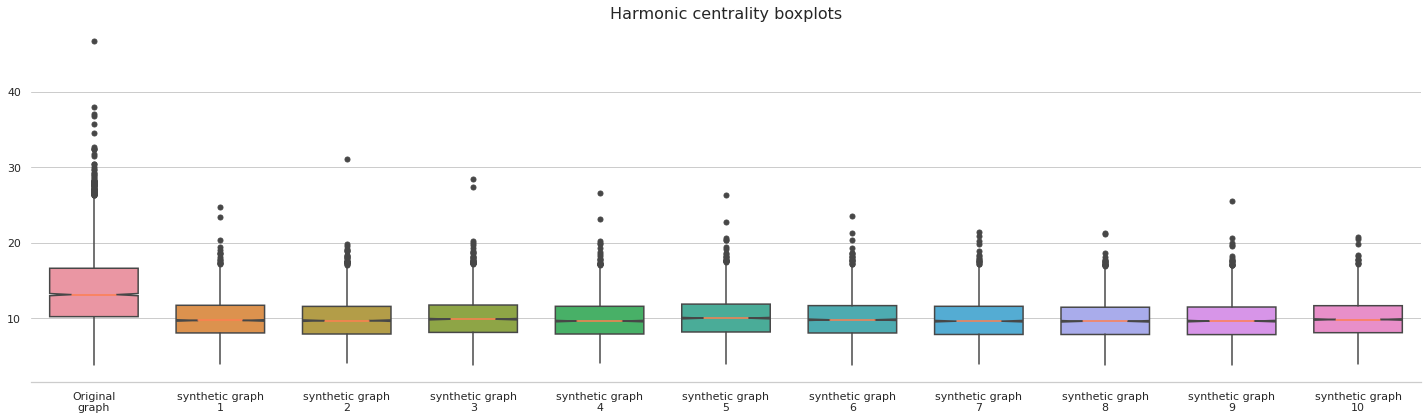

In [ ]:
stat_tests.harmonic_centrality_boxplot()

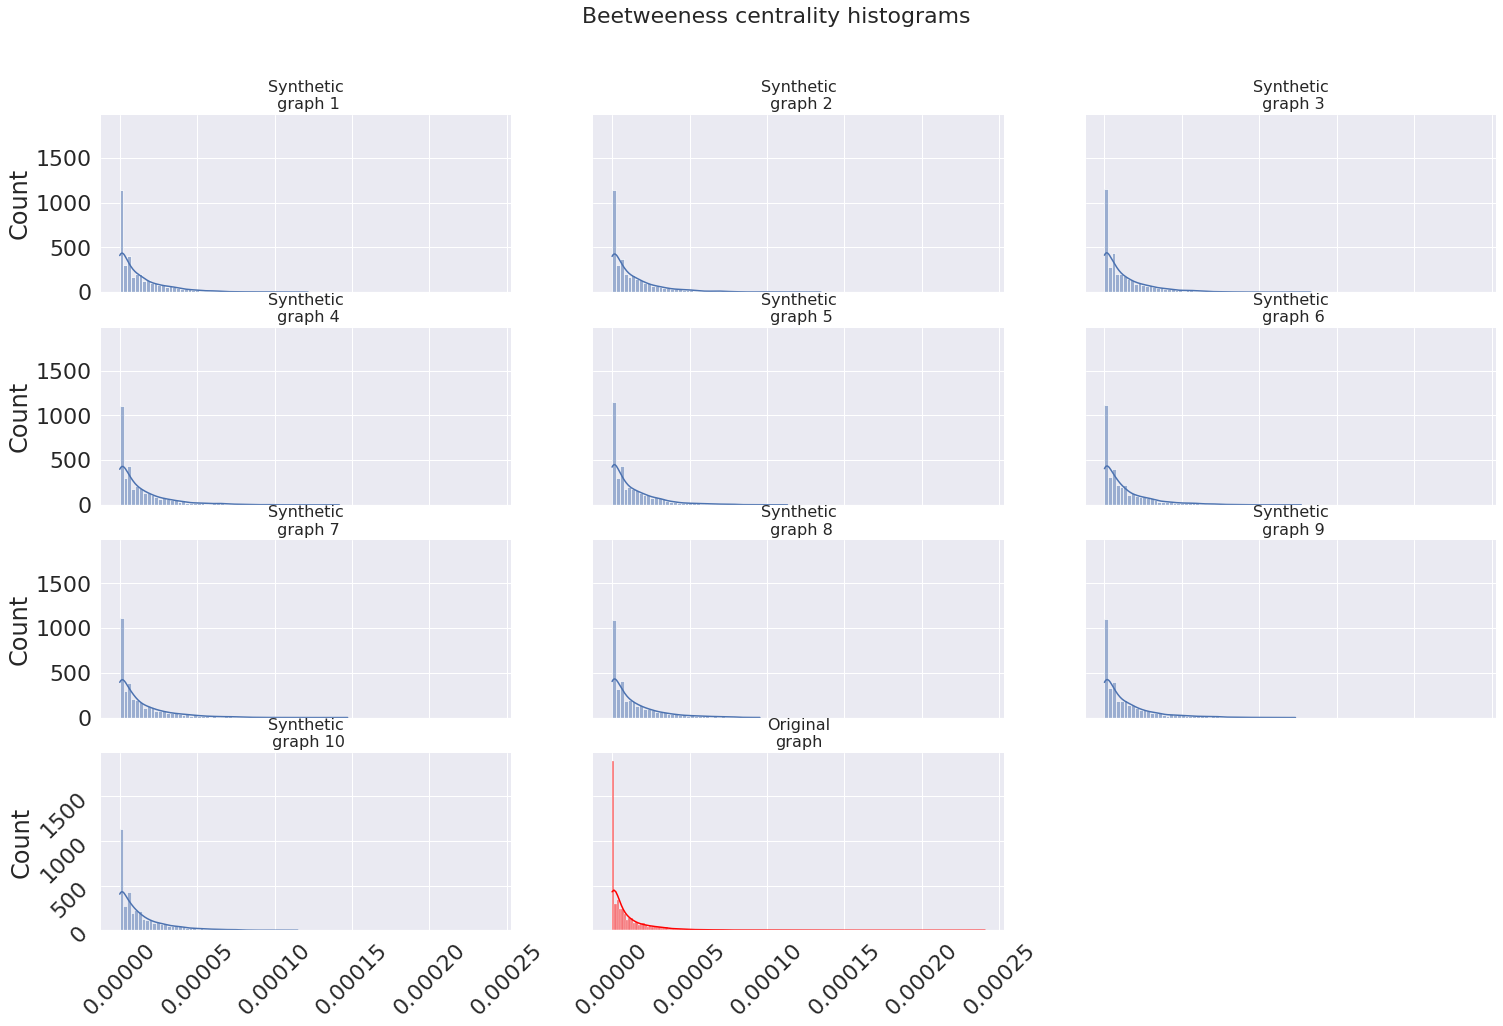

In [ ]:
stat_tests.beetweenness_centrality_hist()

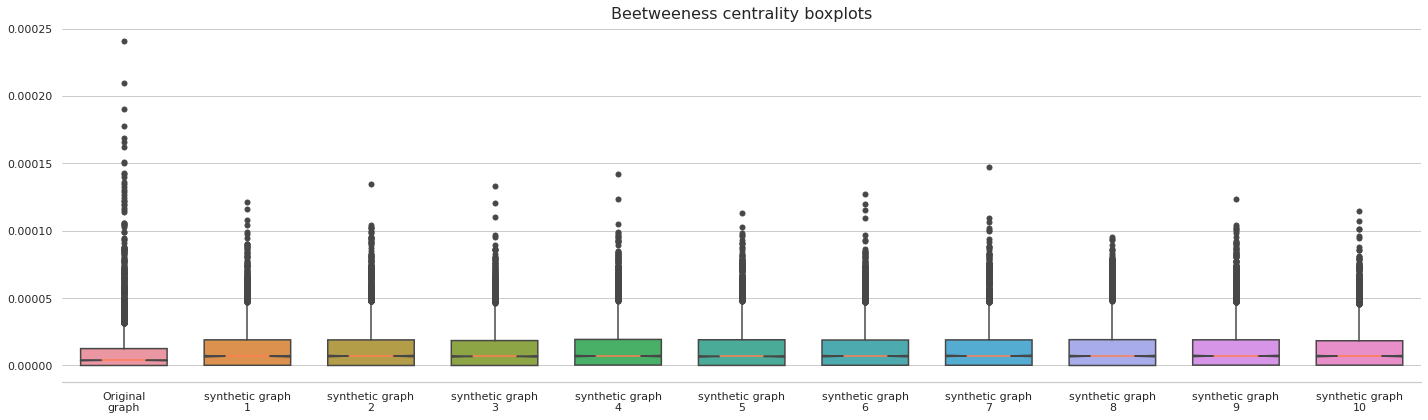

In [ ]:
stat_tests.beetweenness_centrality_boxplot()

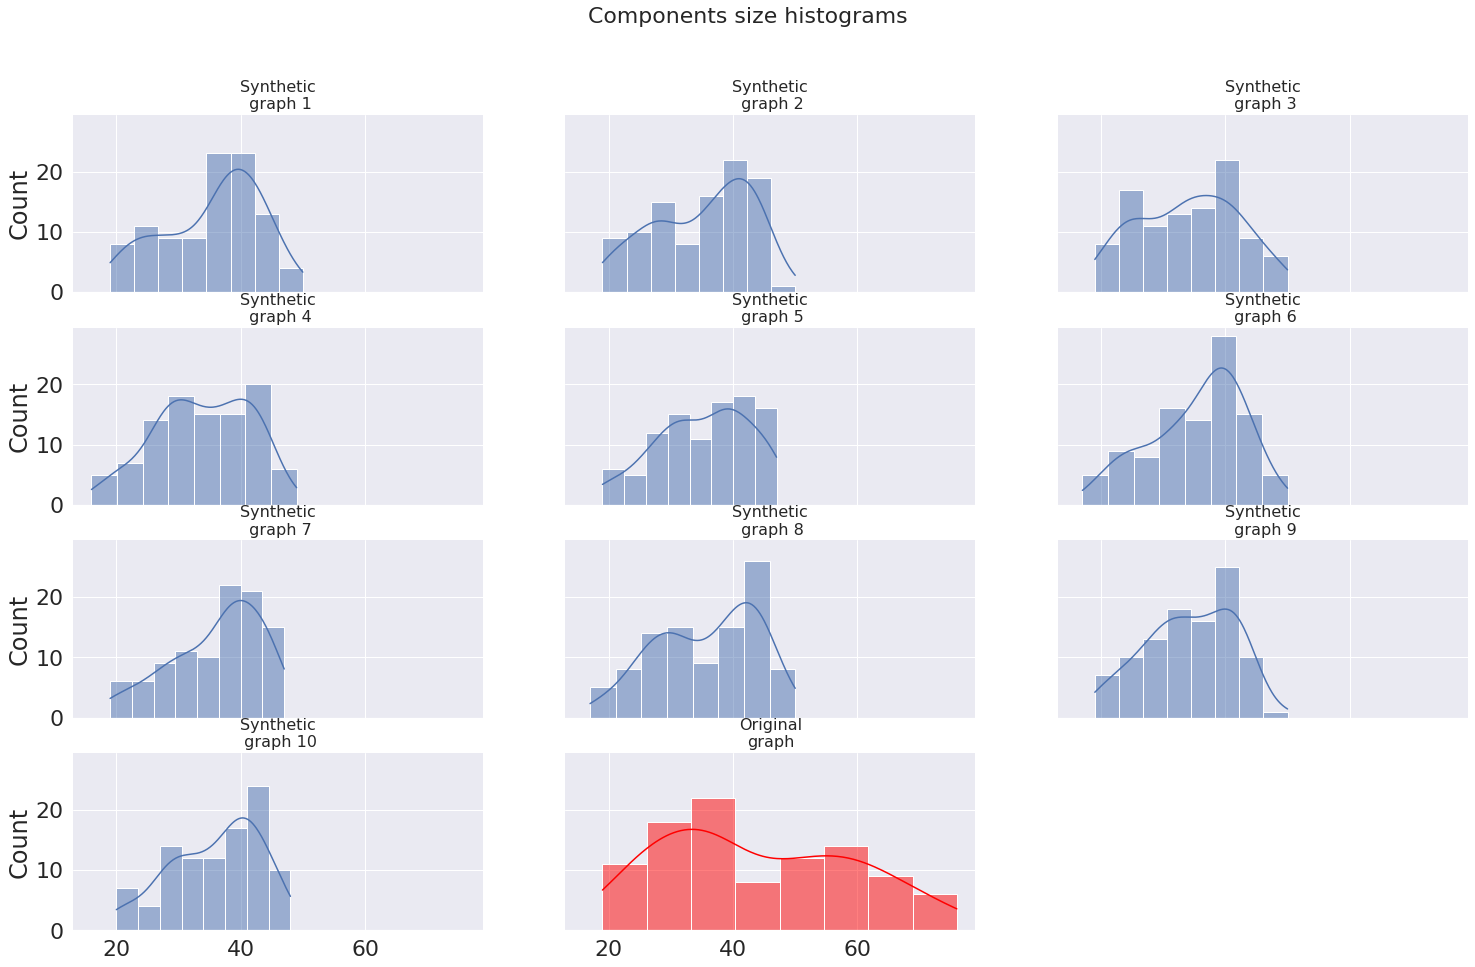

In [64]:
stat_tests.components_sizes_hist()

## Visual similarity tests

In [ ]:
sim_test = vis_sim( orig_filename = "/content/drive/MyDrive/Github/graphgen/datasets/citeseer/graphs/graph", graph_filename = "/content/drive/MyDrive/Github/graphgen/graphs/DFScodeRNN_citeseer_2022-12-21 14:32:51/5/graph",
                   scale= False, dataset='citeseer', load_synt= True, orig_g_count = 13000, synt_g_count = 3000, batch_size = 100, label_name = 'label', ed_label=None, cut_label=False)

In [ ]:
sim_test.measure_similarity()

In [ ]:
sim_test.draw_sim_graphs(5, metric = "euc")

In [ ]:
sim_test_s = vis_sim(orig_filename = "/content/drive/MyDrive/Github/graphgen/datasets/citeseer/graphs/graph", graph_filename = "/content/drive/MyDrive/Github/graphgen/graphs/DFScodeRNN_citeseer_2022-12-21 14:32:51/5/graph",
                   emb_model = "riwalk",scale = False, dataset='citeseer', load_synt= True, orig_g_count = 13000, synt_g_count = 3000, batch_size = 100, label_name = 'label', ed_label=None, cut_label=False)

In [ ]:
sim_test_s.measure_similarity()

In [ ]:
sim_test_s.draw_sim_graphs(20, metric = "euc") 

## Classification tests

In [ ]:
orig_graphs_folder = "/content/drive/MyDrive/Github/graphgen/datasets/citeseer/graphs/graph"
synt_graphs_folder = "/content/drive/MyDrive/Github/graphgen/graphs/DFScodeRNN_citeseer_2022-12-21 14:32:51/5/graph"
# params = {'n_estimators': 1000, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 98, 'class_weight': 'balanced', 'bootstrap': False}
params_graphgen_cite_synth = {'n_estimators': 1400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 43, 'class_weight': 'balanced', 'bootstrap': False}
params_graphgen_cite_synth, graphgen_citeseer_synt = class_test(30, False, orig_graphs_folder, synt_graphs_folder, dataset = 'citeseer', orig_g_count =  13000, synt_g_count = 3000,
                                                                ed_label = None, cut_label = False, model_params=params_graphgen_cite_synth, riwalk = True, SMOTE= False, balance = True)

In [ ]:
print(params_graphgen_cite_synth)

{'n_estimators': 1400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 43, 'class_weight': 'balanced', 'bootstrap': False}


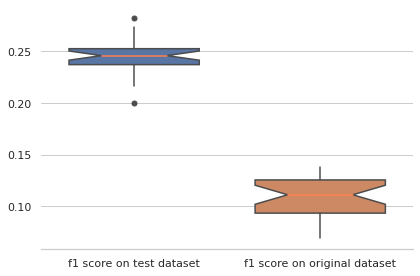

In [ ]:
draw_accuracy_boxplot(graphgen_citeseer_synt)

In [ ]:
params_graphgen_cite_orig, graphgen_citeseer_orig = class_test(10, True, orig_graphs_folder, synt_graphs_folder, dataset = 'citeseer', orig_g_count =  13000, synt_g_count = 3000,
                                                               ed_label = None, cut_label = False, model_params=params_graphgen_cite_synth, riwalk = True, SMOTE= False, balance = True)

In [ ]:
print(params_graphgen_cite_orig)

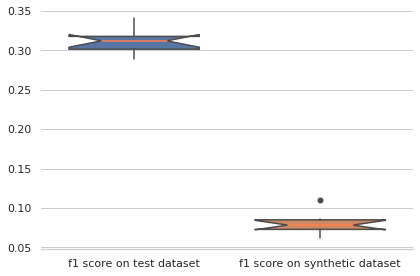

In [ ]:
draw_accuracy_boxplot(graphgen_citeseer_orig )

# Enzymes dataset

---

## Statistical tests

In [ ]:
orig_filename = "/content/drive/MyDrive/Github/graphgen/datasets/ENZYMES/graphs/graph"
graphs_folder = "/content/drive/MyDrive/Github/graphgen/graphs/DFScodeRNN_ENZYMES_2022-12-23 16:38:09/2000/graph"

stat_tests = graph_statistics(None, orig_filename, graphs_folder, dataset = 'ENZYMES', orig_graph_cnt = 570, gen_graph_cnt = 4000, another_load_method = True, cut_label=True)

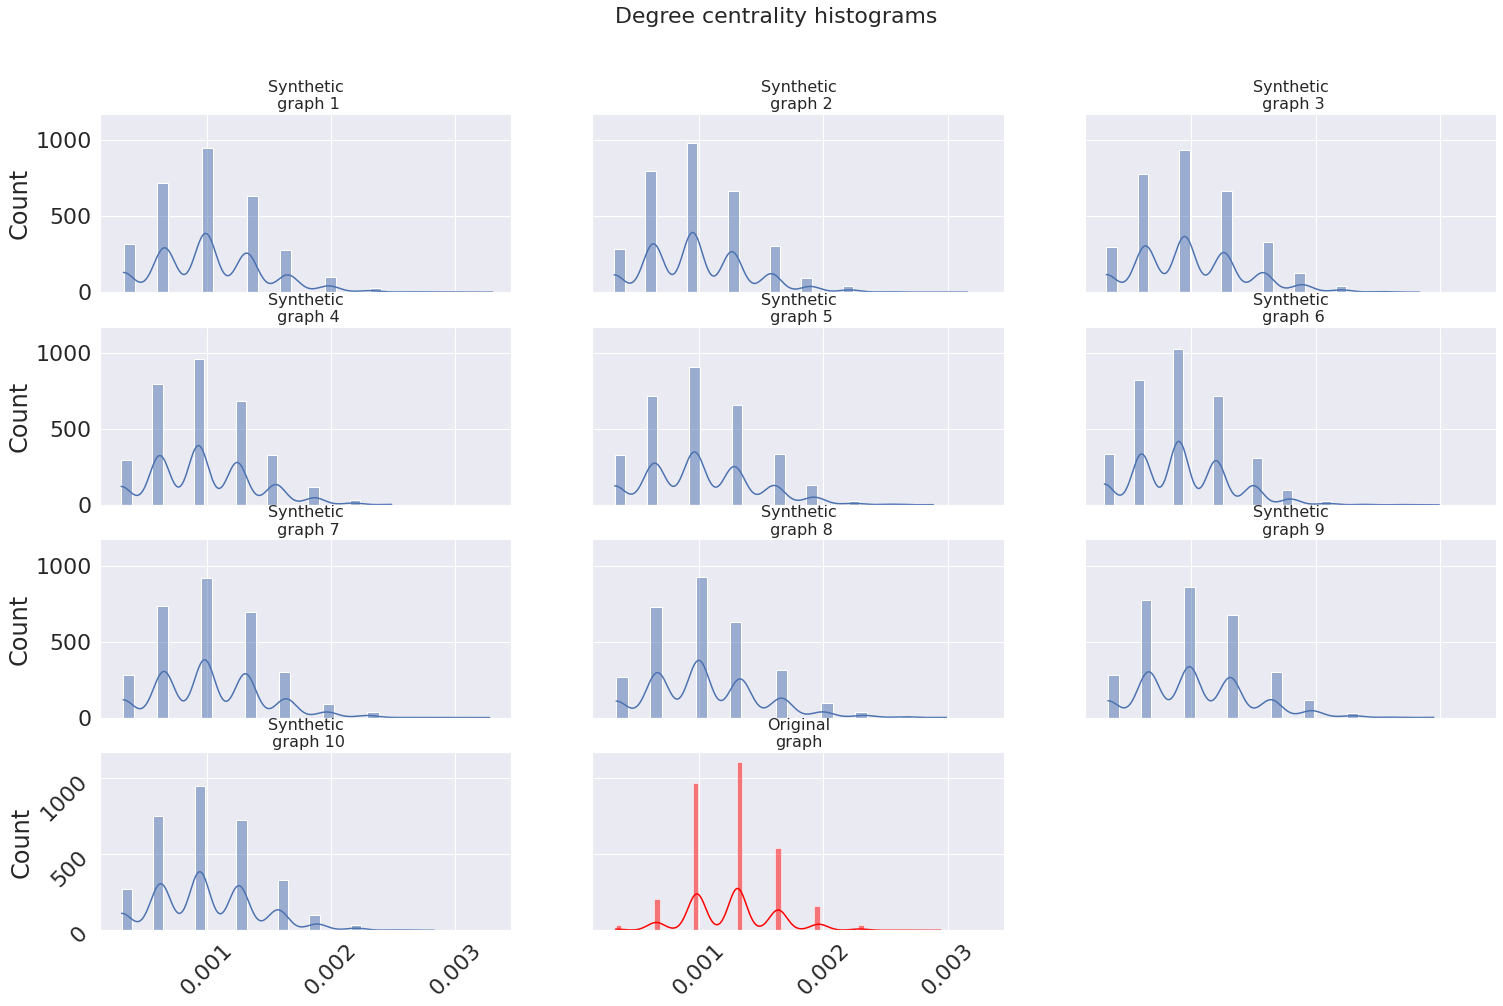

In [ ]:
stat_tests.degree_centrality_hist()

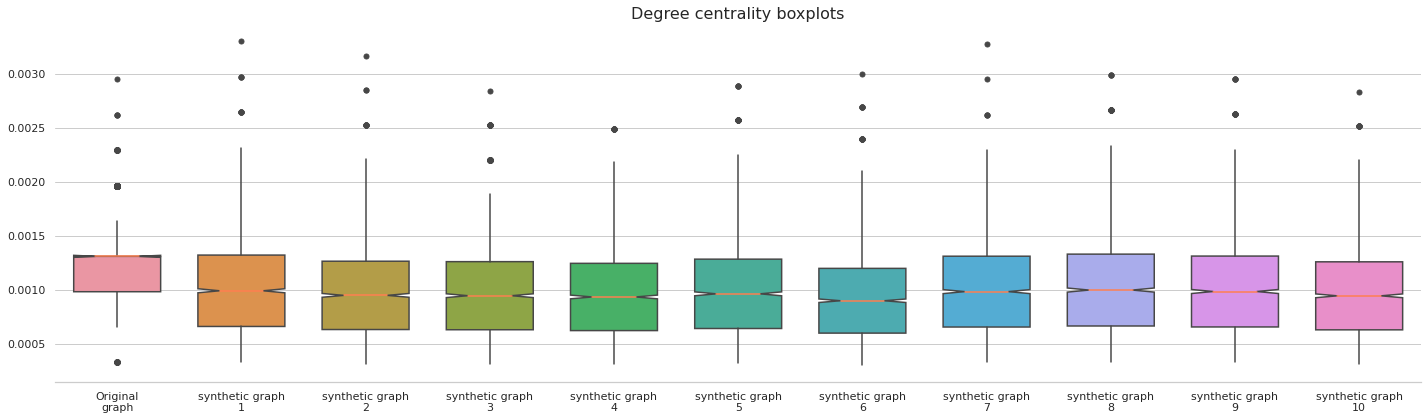

In [ ]:
stat_tests.degree_centrality_boxplot()

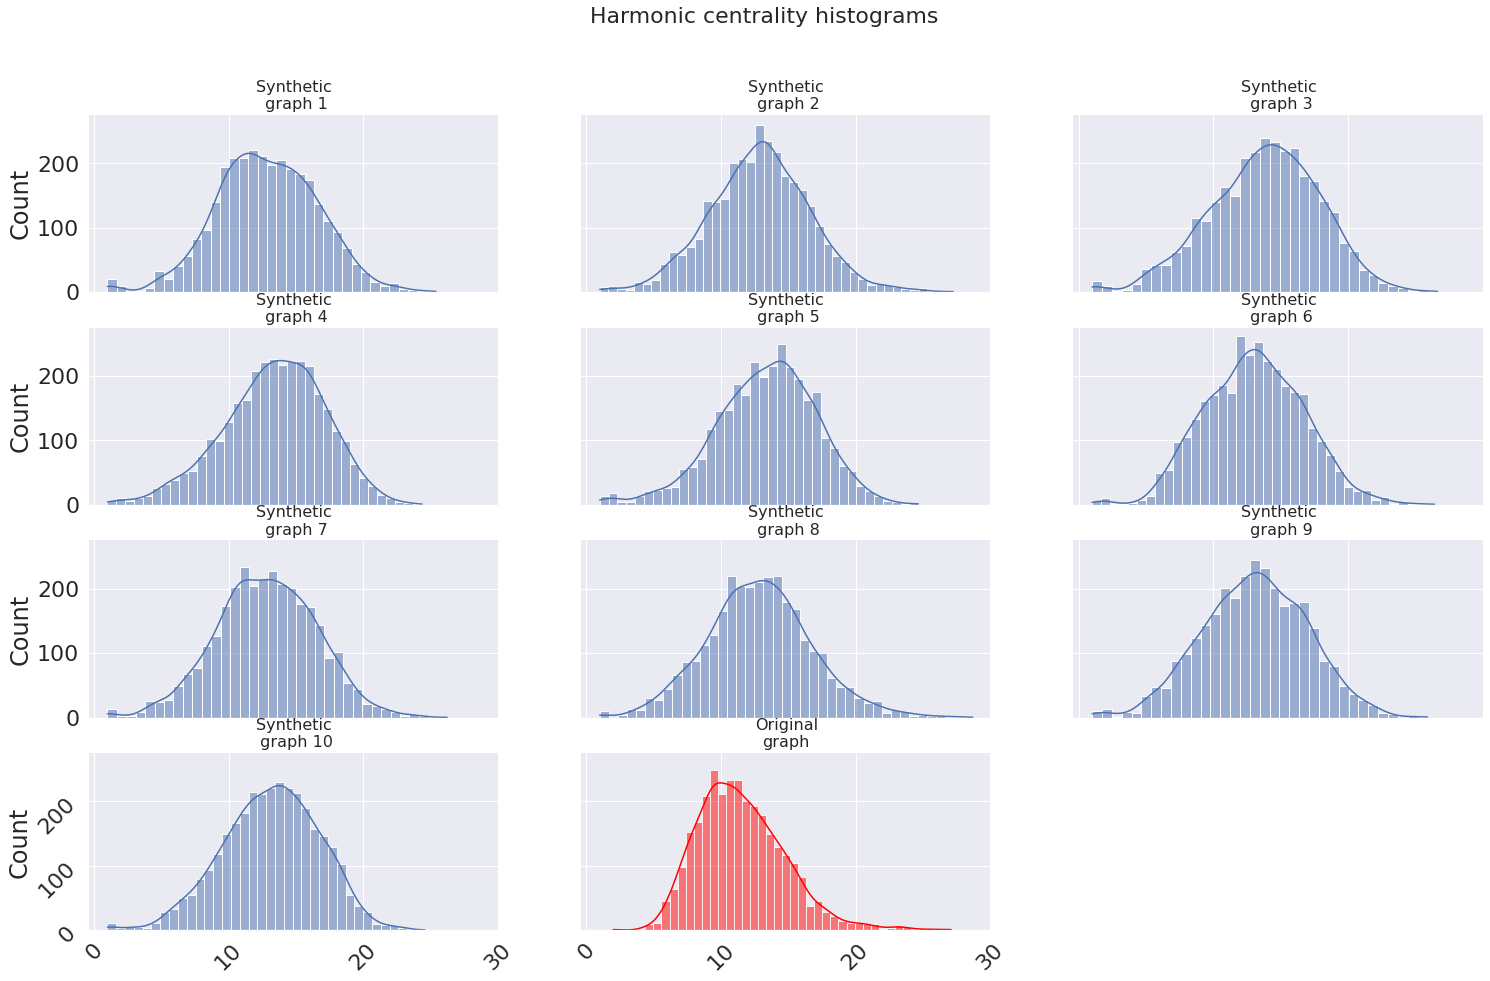

In [ ]:
stat_tests.harmonic_centrality_hist()

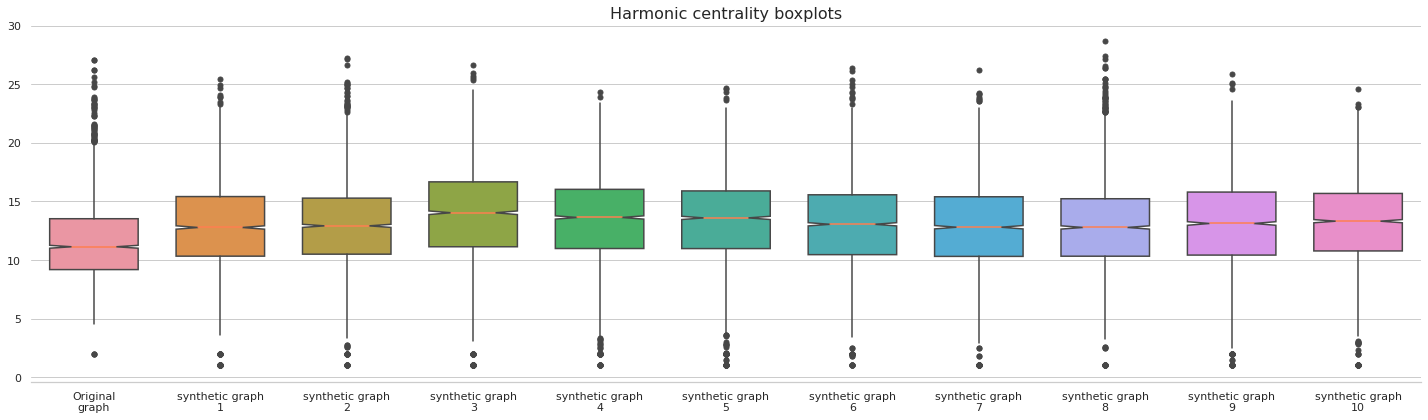

In [ ]:
stat_tests.harmonic_centrality_boxplot()

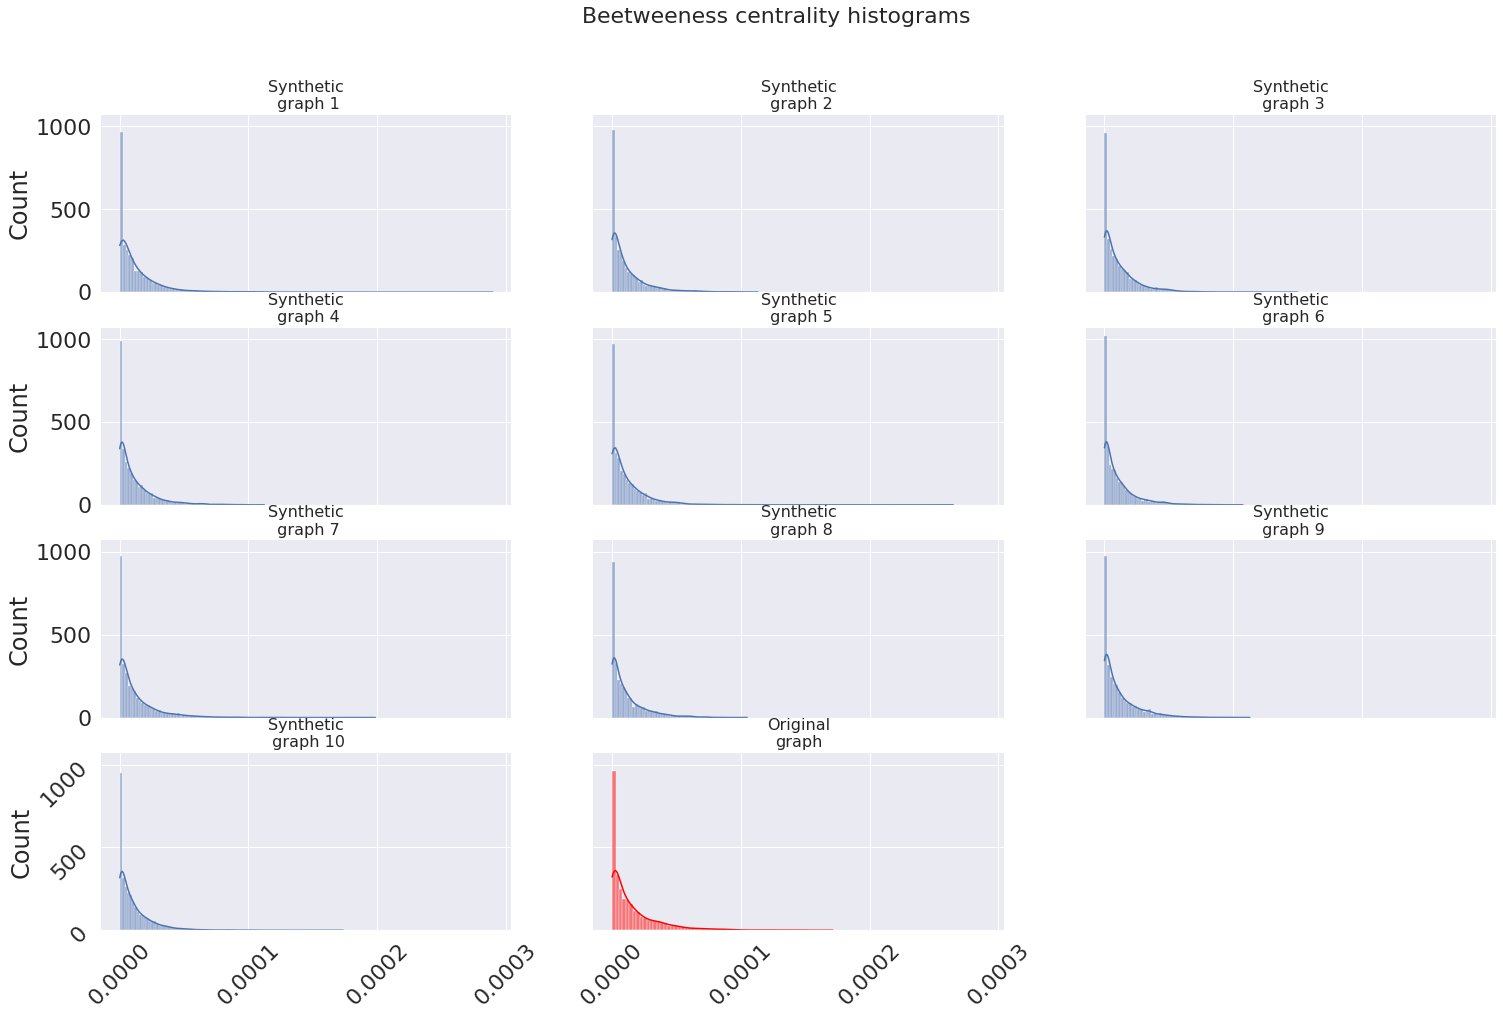

In [ ]:
stat_tests.beetweenness_centrality_hist()

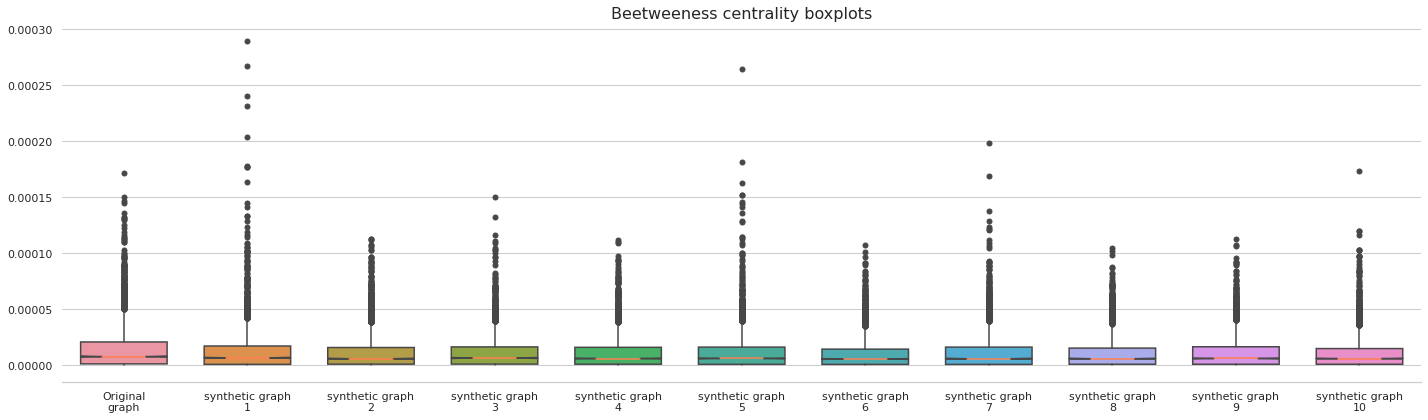

In [ ]:
stat_tests.beetweenness_centrality_boxplot()

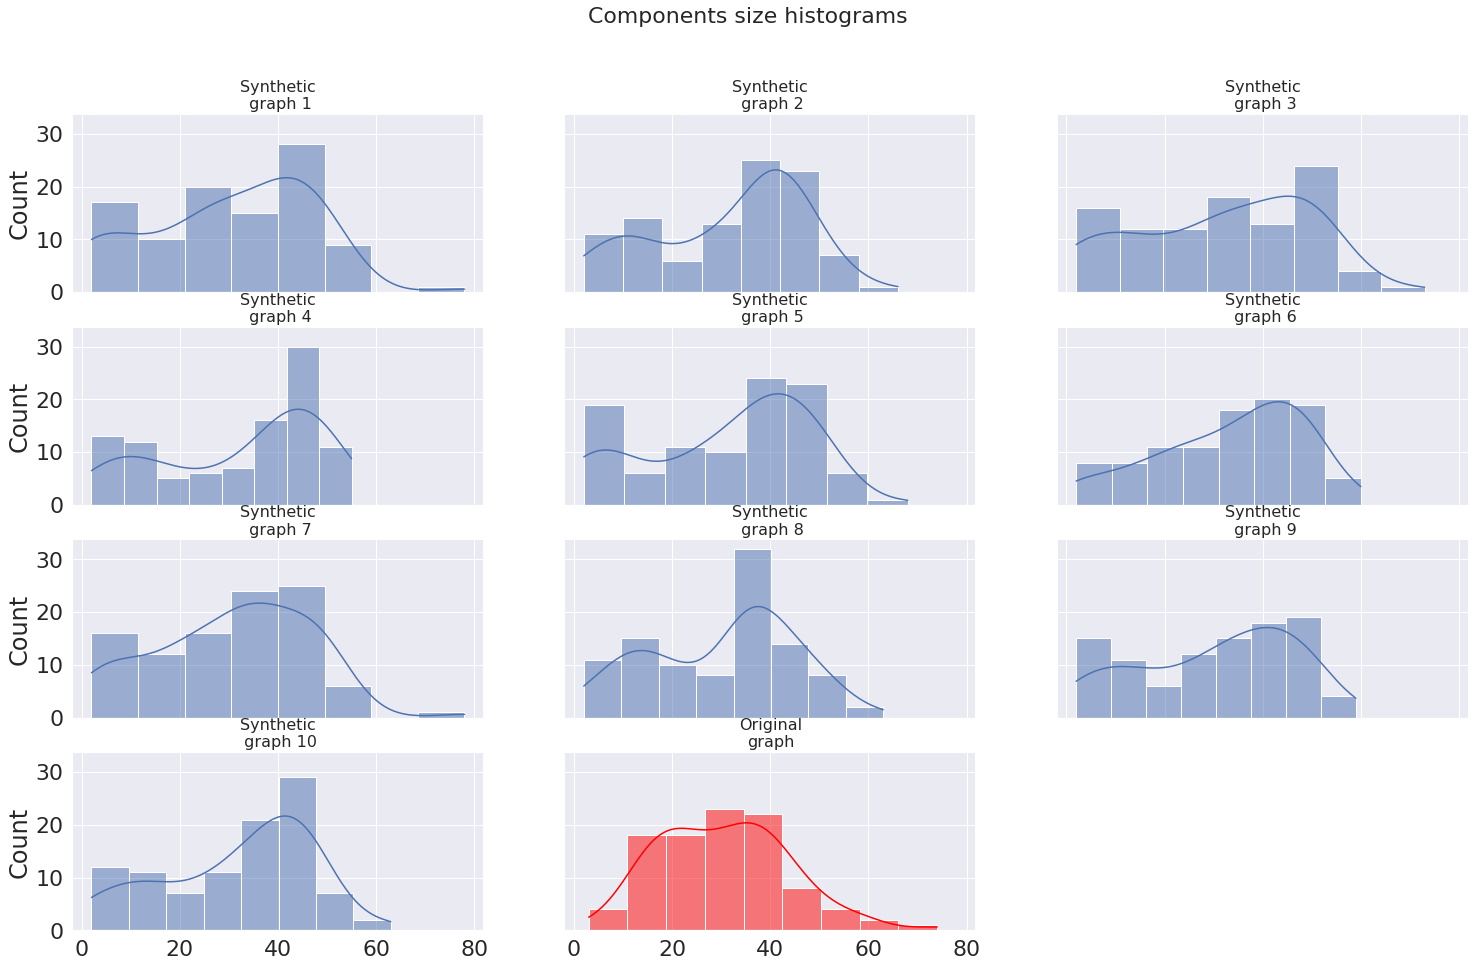

In [ ]:
stat_tests.components_sizes_hist()

## Visual similarity tests

In [ ]:
sim_test = vis_sim(orig_filename = orig_filename, graph_filename = graphs_folder,
                   emb_model = "riwalk", scale = False, dataset='ENZYMES', load_synt= True, orig_g_count = 570, synt_g_count = 3000, batch_size = 100, label_name = 'label', ed_label=None, cut_label=False)

In [ ]:
sim_test.measure_similarity()

In [ ]:
sim_test.draw_sim_graphs(15, metric = "euc")

## Classification tests

In [ ]:
orig_filename = "/content/drive/MyDrive/Github/graphgen/datasets/ENZYMES/graphs/graph"
graphs_folder = "/content/drive/MyDrive/Github/graphgen/graphs/DFScodeRNN_ENZYMES_2022-12-23 16:38:09/2000/graph"
params_graphgen_enz_synth = {'n_estimators': 1800, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 32, 'class_weight': 'balanced', 'bootstrap': False}
params_graphgen_enz_synth, graphgen_enzymes_synt = class_test(30, False, orig_filename, graphs_folder, dataset = 'ENZYMES', orig_g_count =  570, synt_g_count = 4000,
                                                              ed_label = None, cut_label = True, model_params = params_graphgen_enz_synth, riwalk = True, SMOTE= False, balance = True)

In [ ]:
print(params_graphgen_enz_synth)

{'n_estimators': 1800, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 32, 'class_weight': 'balanced', 'bootstrap': False}


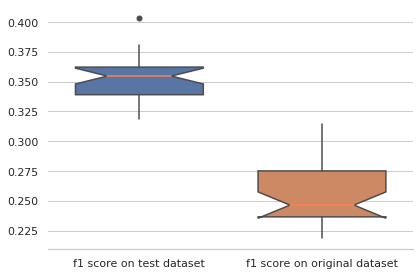

In [ ]:
draw_accuracy_boxplot(graphgen_enzymes_synt)

In [ ]:
params_graphgen_enz_orig, graphgen_enzymes_orig = class_test(10, True, orig_filename, graphs_folder, dataset = 'ENZYMES', orig_g_count =  570, synt_g_count = 4000,
                                                             ed_label = None, cut_label = True, model_params = params_graphgen_enz_synth, riwalk = True, SMOTE= False, balance = True)

In [ ]:
print(params_graphgen_enz_orig)

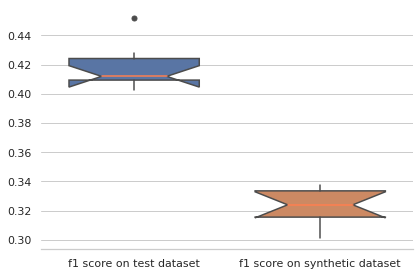

In [ ]:
draw_accuracy_boxplot(graphgen_enzymes_orig)

# Citeseer dataset (20 epoch trained) (to test)

---

## Statistical tests

In [ ]:
orig_filename = "/content/drive/MyDrive/Github/graphgen/datasets/citeseer/graphs/graph"
graphs_folder = "/content/drive/MyDrive/Github/graphgen/graphs/DFScodeRNN_citeseer_2022-12-21 14:32:51/20/graph"

stat_tests = graph_statistics(None, orig_filename, graphs_folder, another_load_method = True)

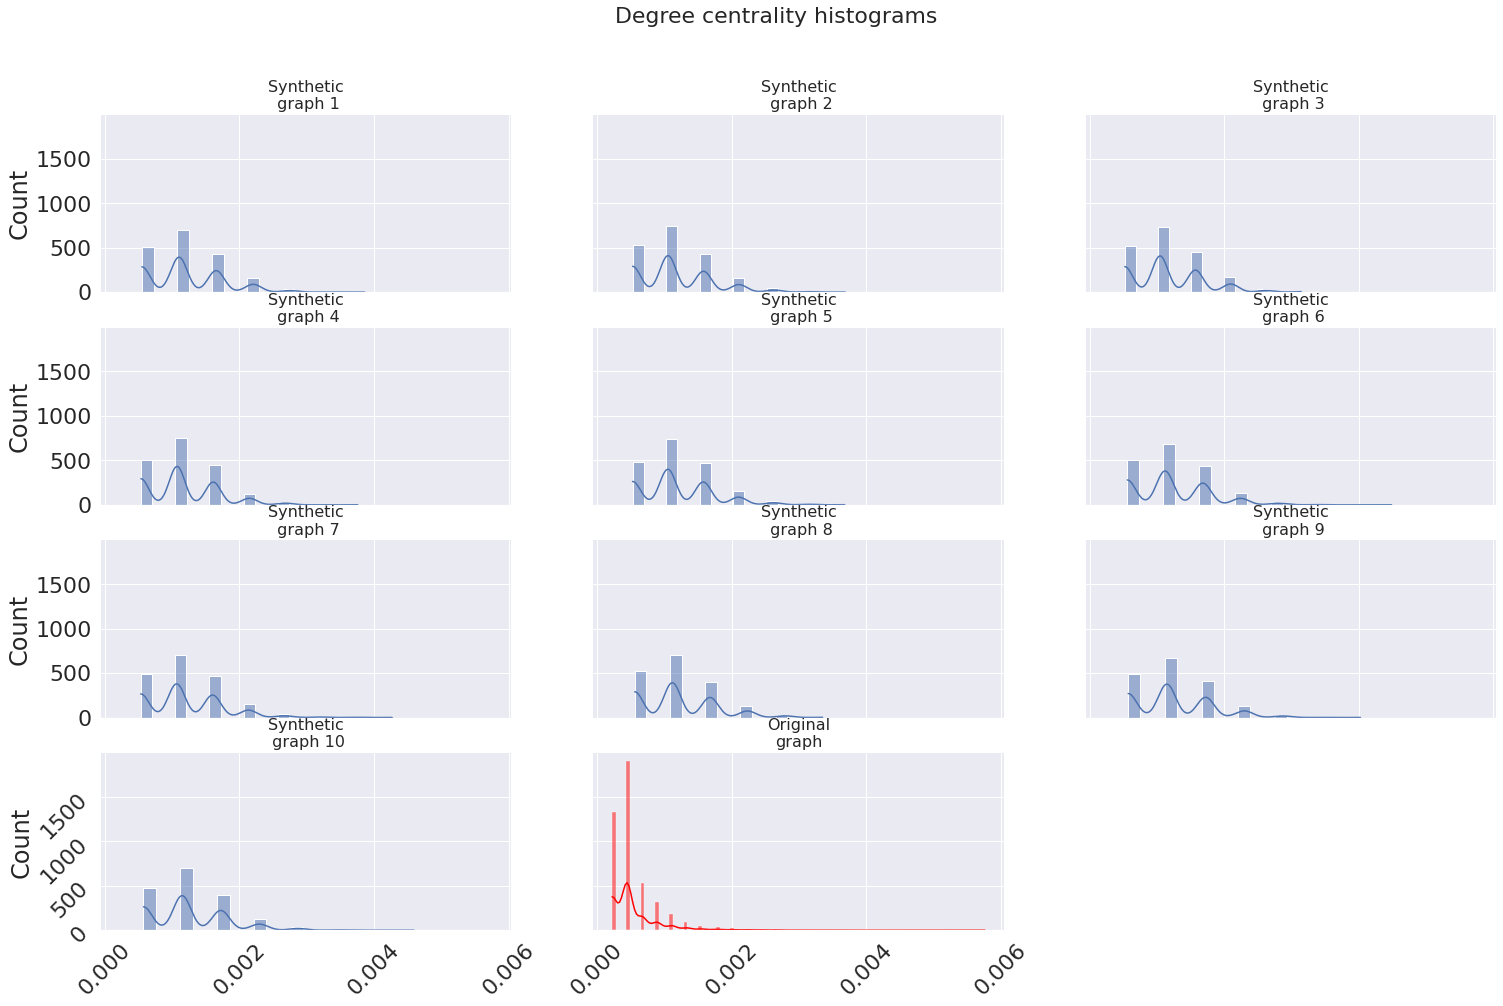

In [ ]:
stat_tests.degree_centrality_hist()

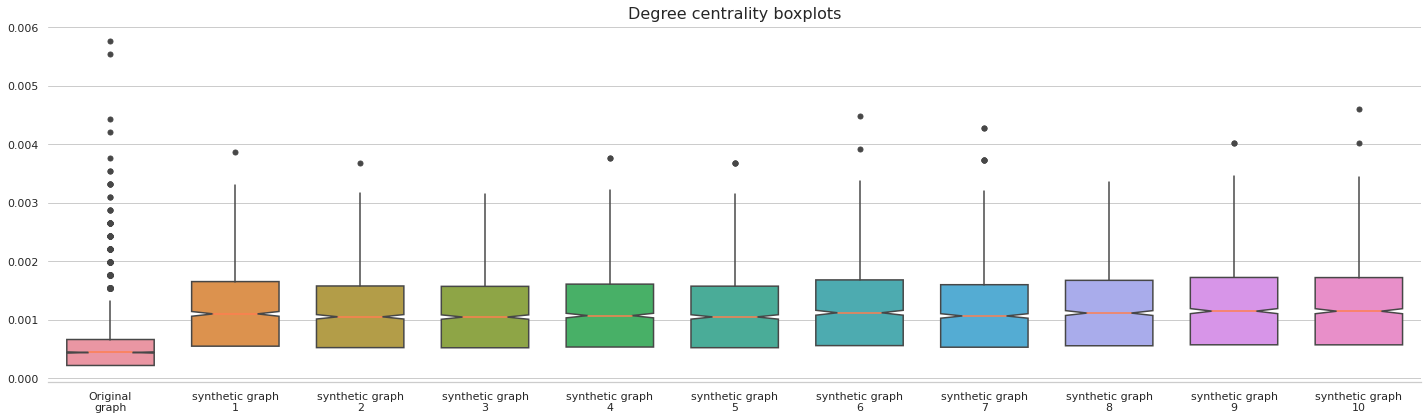

In [ ]:
stat_tests.degree_centrality_boxplot()

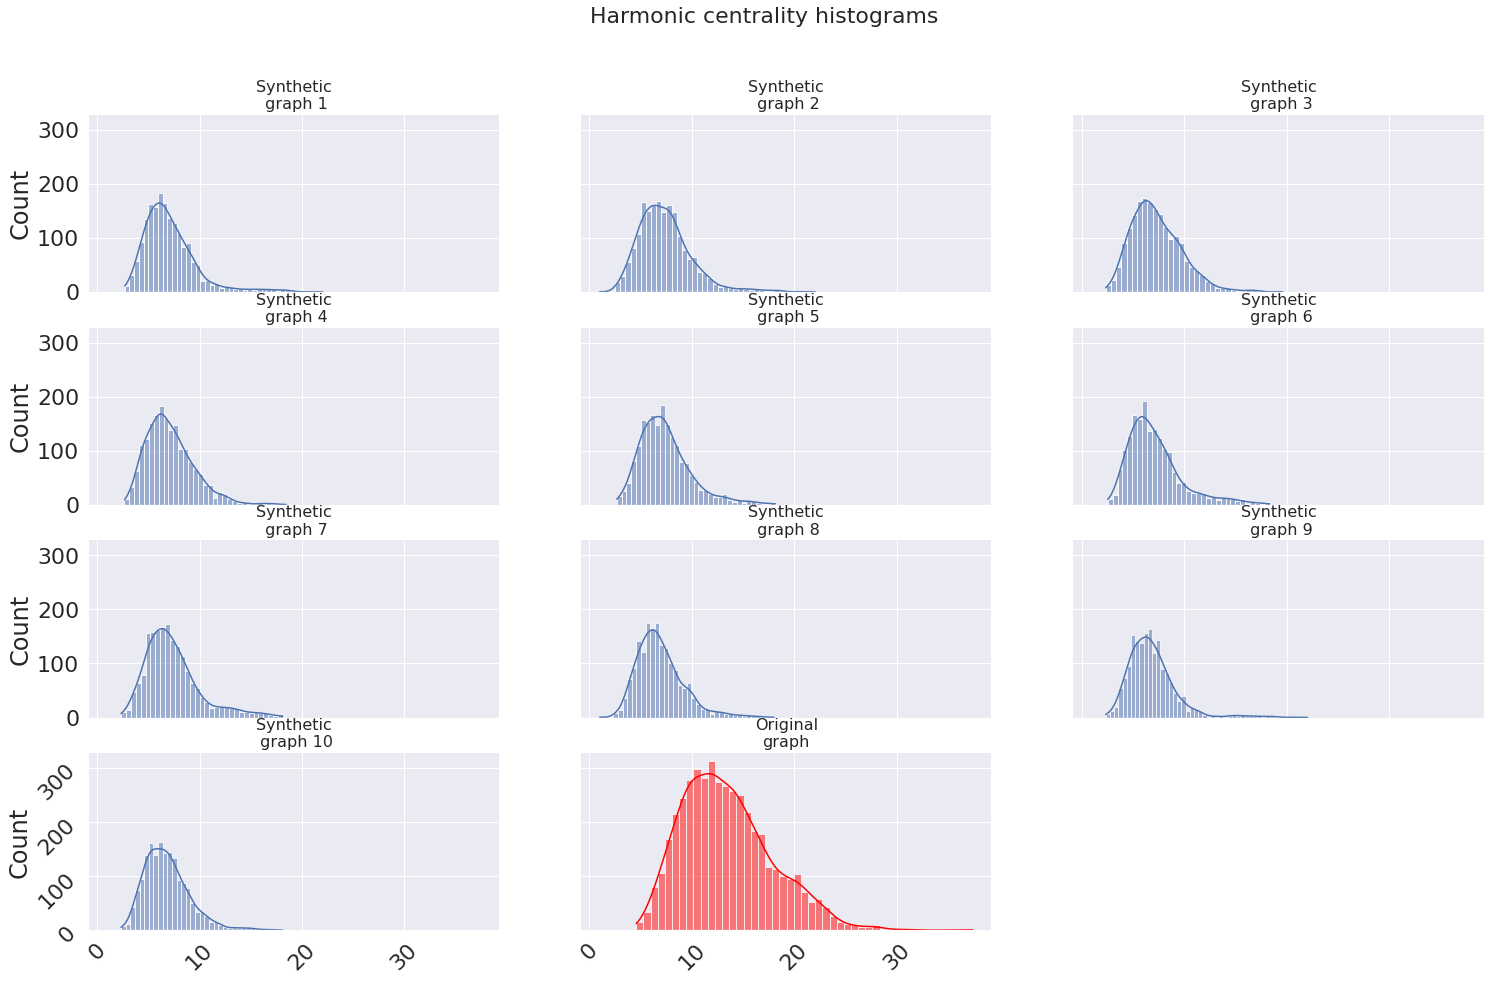

In [ ]:
stat_tests.harmonic_centrality_hist()

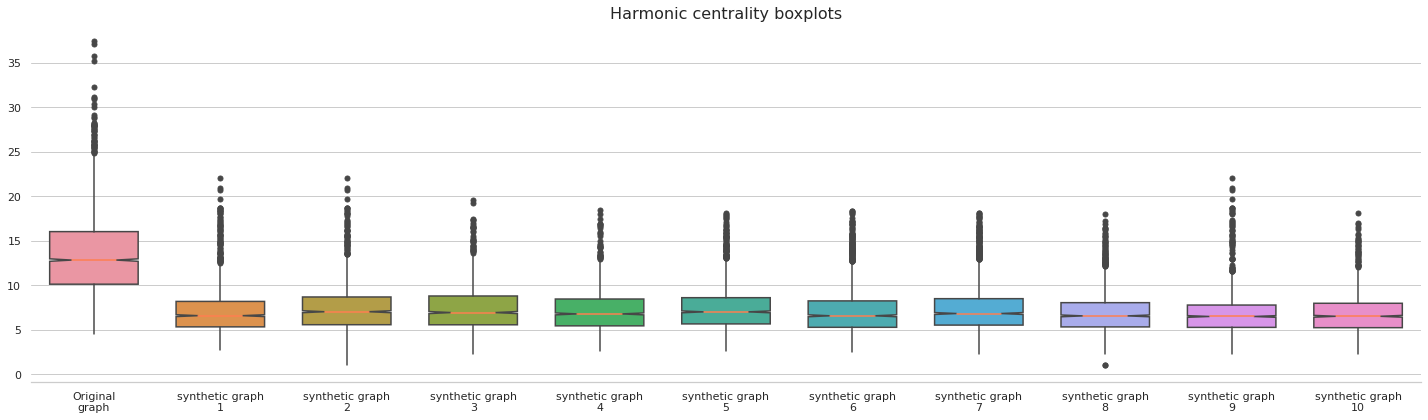

In [ ]:
stat_tests.harmonic_centrality_boxplot()

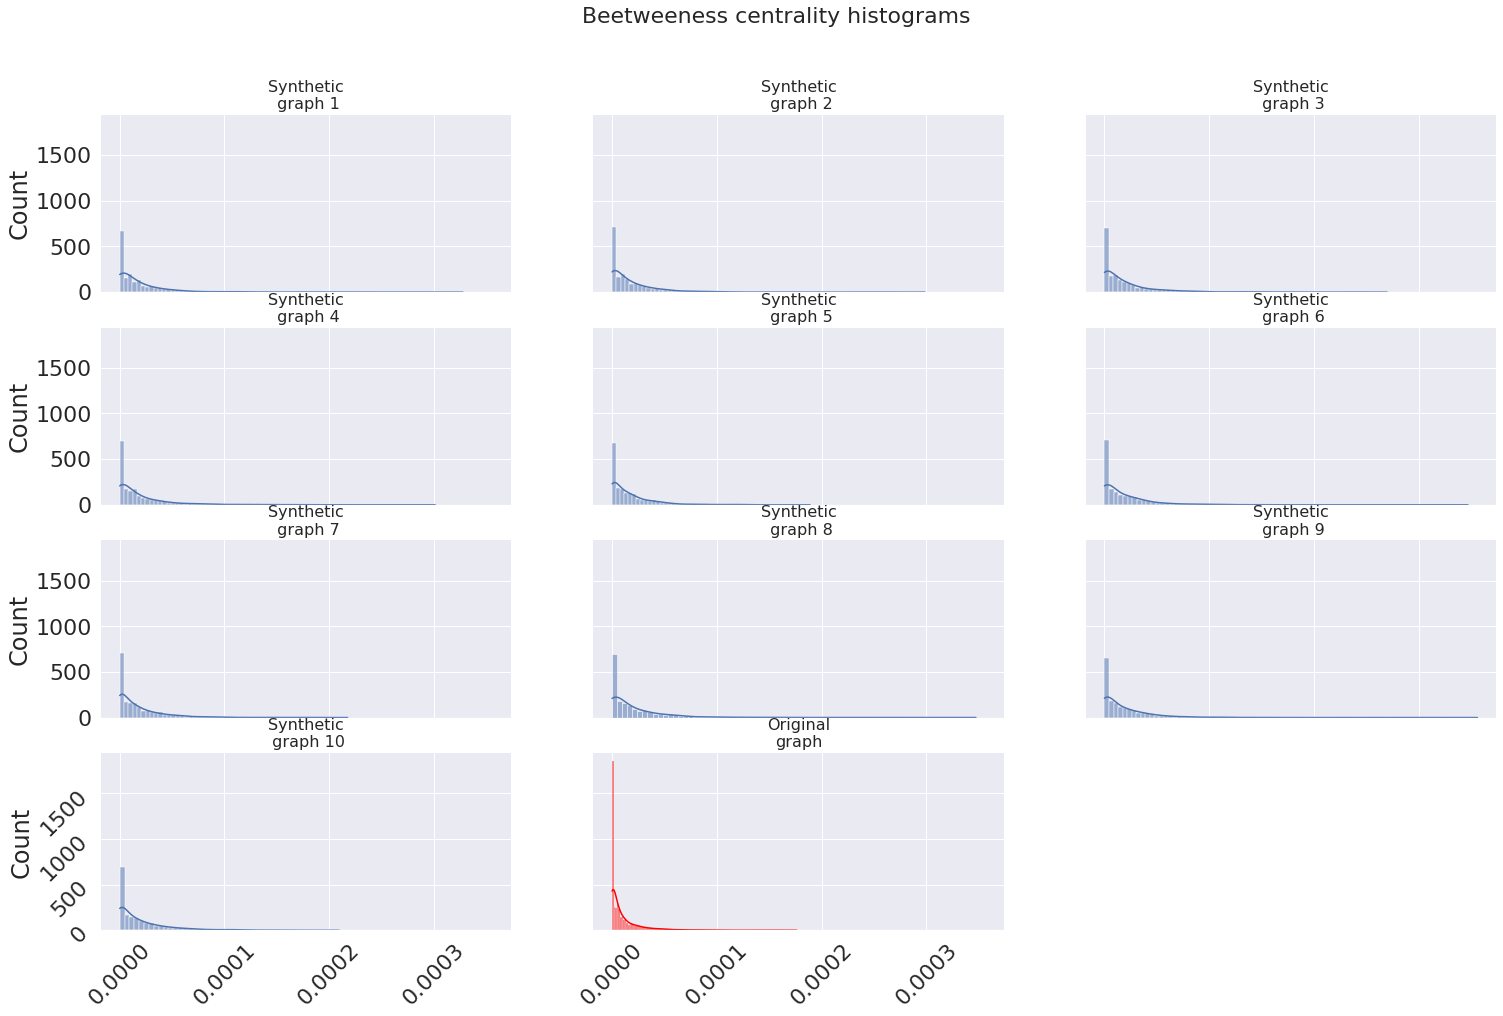

In [ ]:
stat_tests.beetweenness_centrality_hist()

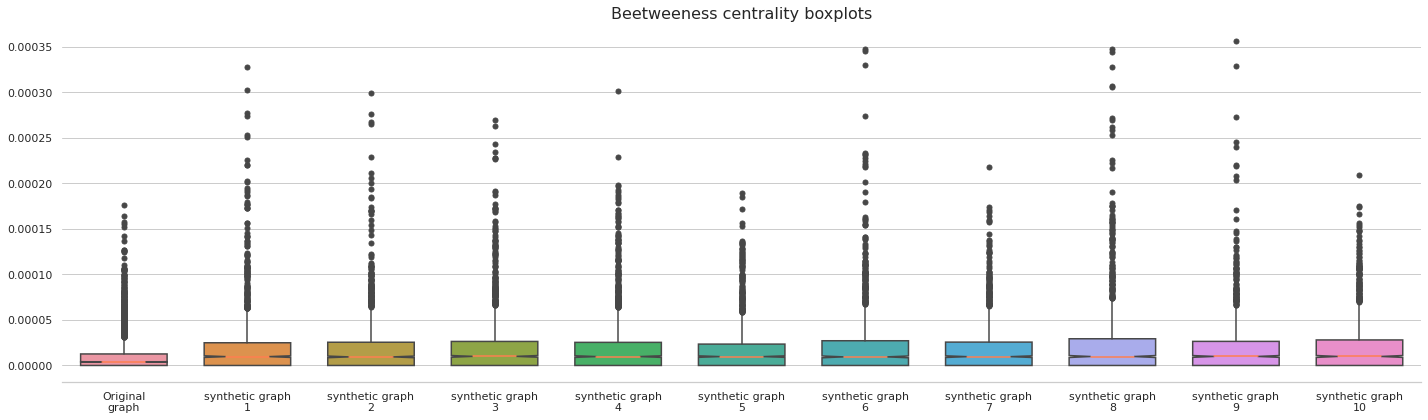

In [ ]:
stat_tests.beetweenness_centrality_boxplot()

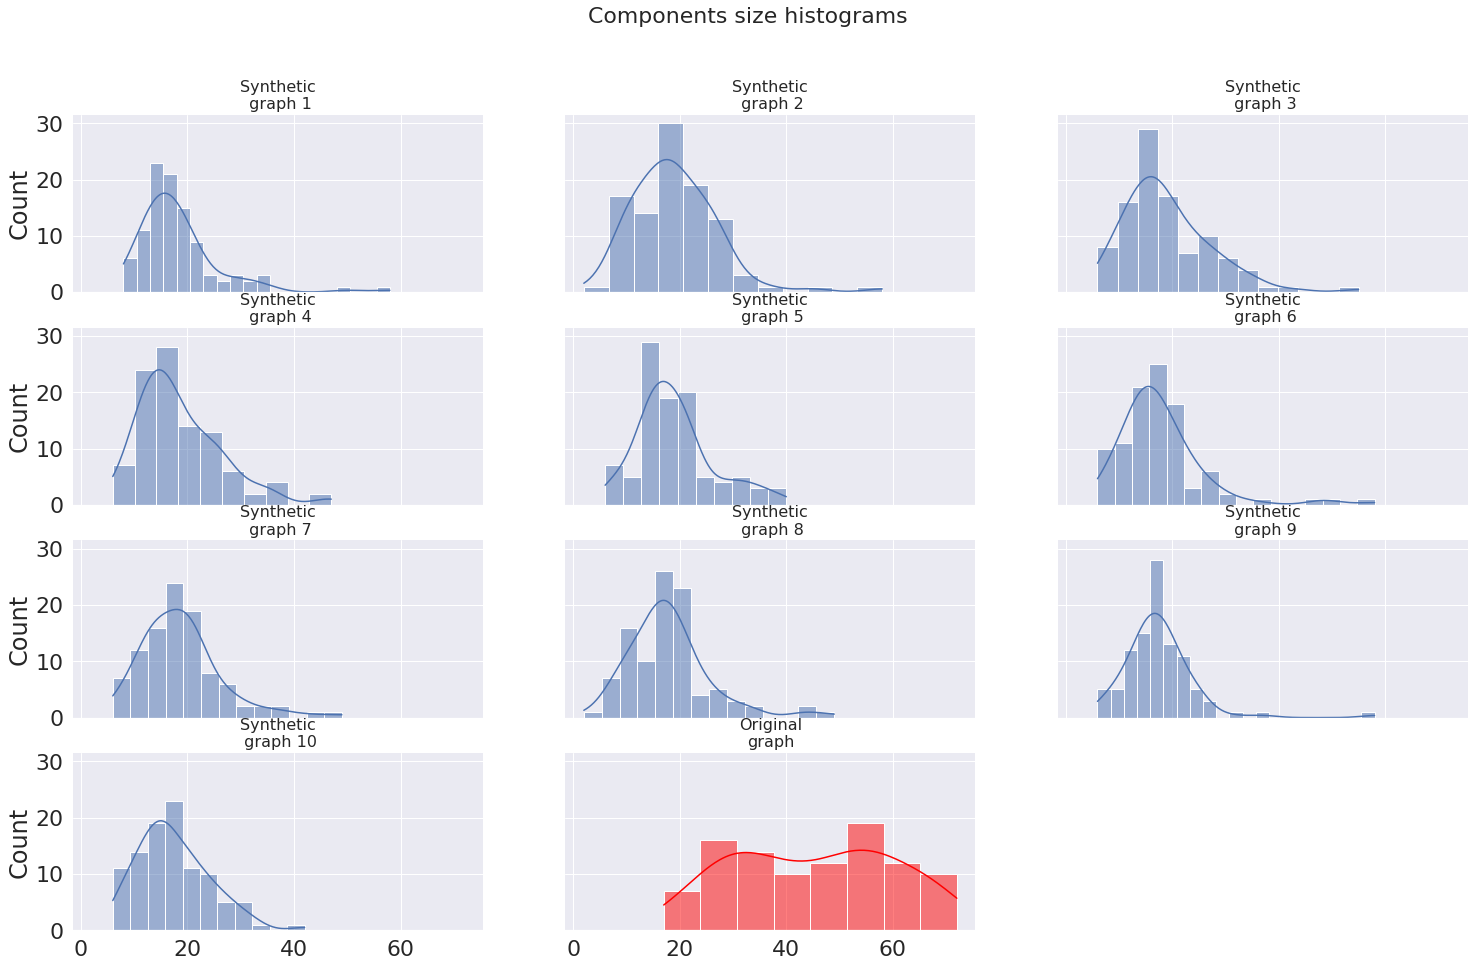

In [ ]:
stat_tests.components_sizes_hist()

## Visual similarity tests

In [ ]:
sim_test = vis_sim(orig_filename = orig_filename, graph_filename = graphs_folder,
                   emb_model = "riwalk", scale = False, dataset='citeseer', load_synt= True, orig_g_count = 13000, synt_g_count = 3000, batch_size = 100, label_name = 'label', ed_label=None, cut_label=False)

In [ ]:
sim_test.measure_similarity()

In [ ]:
sim_test.draw_sim_graphs(15, metric = "euc")

## Classification tests

In [ ]:
orig_graphs_folder = "/content/drive/MyDrive/Github/graphgen/datasets/citeseer/graphs/graph"
synt_graphs_folder = "/content/drive/MyDrive/Github/graphgen/graphs/DFScodeRNN_citeseer_2022-12-21 14:32:51/20/graph"
params_graphgen_cite_20_synth = {'n_estimators': 1400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 43, 'class_weight': 'balanced', 'bootstrap': False}
params_graphgen_cite_20_synth, graphgen_citeseer_20_synt = class_test(30, False, orig_graphs_folder, synt_graphs_folder, dataset = 'citeseer', orig_g_count =  13000, synt_g_count = 3000,
                                                                      ed_label = None, cut_label = False, model_params=params_graphgen_cite_20_synth, riwalk = True, SMOTE= False, balance = True)

In [ ]:
print(params_graphgen_cite_20_synth)

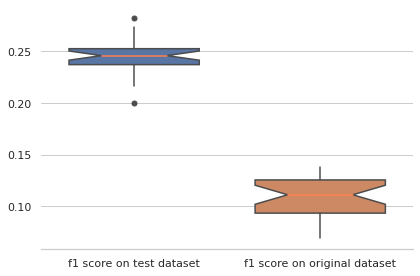

In [ ]:
draw_accuracy_boxplot(graphgen_citeseer_synt)

In [ ]:
params_graphgen_cite_20_orig, graphgen_citeseer_20_orig = class_test(10, True, orig_graphs_folder, synt_graphs_folder, dataset = 'citeseer', orig_g_count =  13000, synt_g_count = 3000,
                                                                     ed_label = None, cut_label = False, model_params= params_graphgen_cite_20_synth, riwalk = True, SMOTE= False, balance = True)

In [ ]:
print(params_graphgen_cite_20_orig)

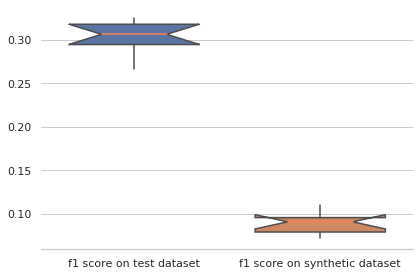

In [ ]:
draw_accuracy_boxplot(graphgen_citeseer_20_orig)

# Cora dataset with larger graphs (to test)

---

## Statistical tests

In [ ]:
orig_graphs_folder = '/content/drive/MyDrive/Github/graphgen/datasets/cora/graphs/graph'
synt_graphs_folder = '/content/drive/MyDrive/Github/graphgen/graphs/DFScodeRNN_cora_2022-12-27 00:24:56/5180/graph'

stat_tests = graph_statistics(None, orig_graphs_folder , synt_graphs_folder, dataset = 'cora', orig_graph_cnt = 480, gen_graph_cnt = 3200, another_load_method = True, batch_size=50)

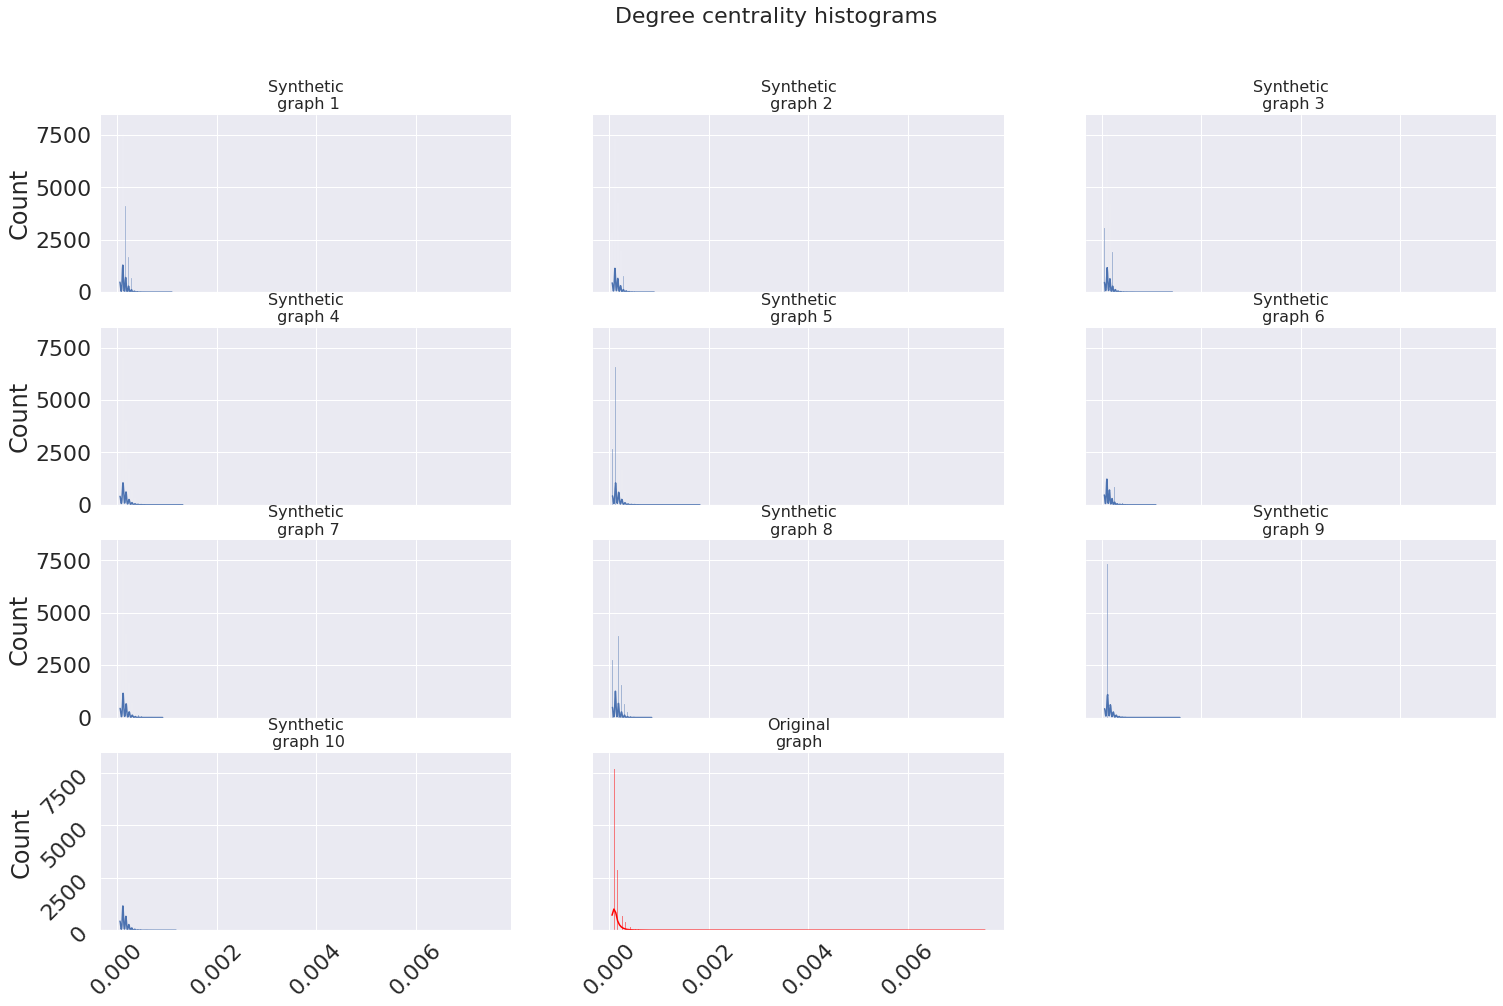

In [ ]:
stat_tests.degree_centrality_hist()

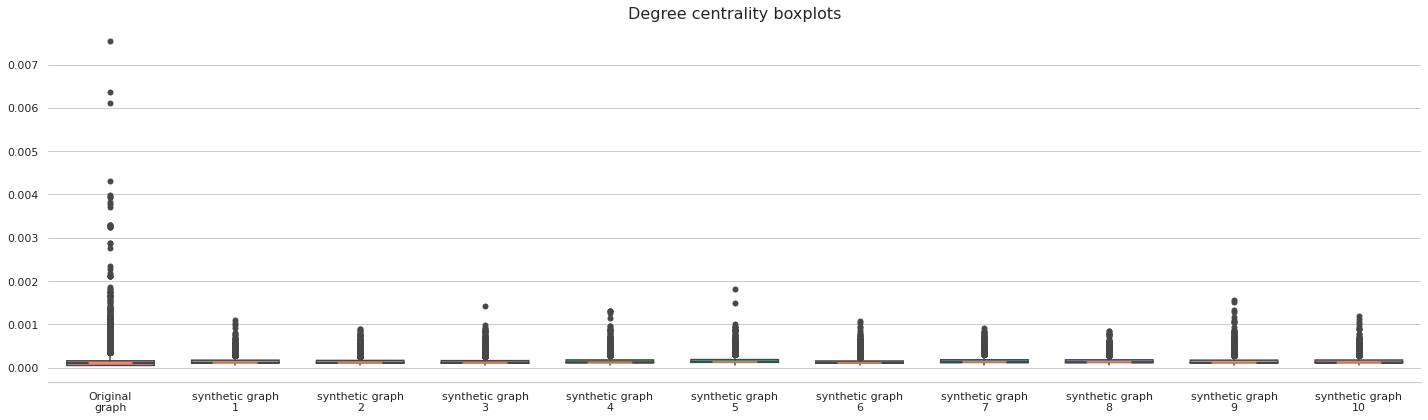

In [ ]:
stat_tests.degree_centrality_boxplot()

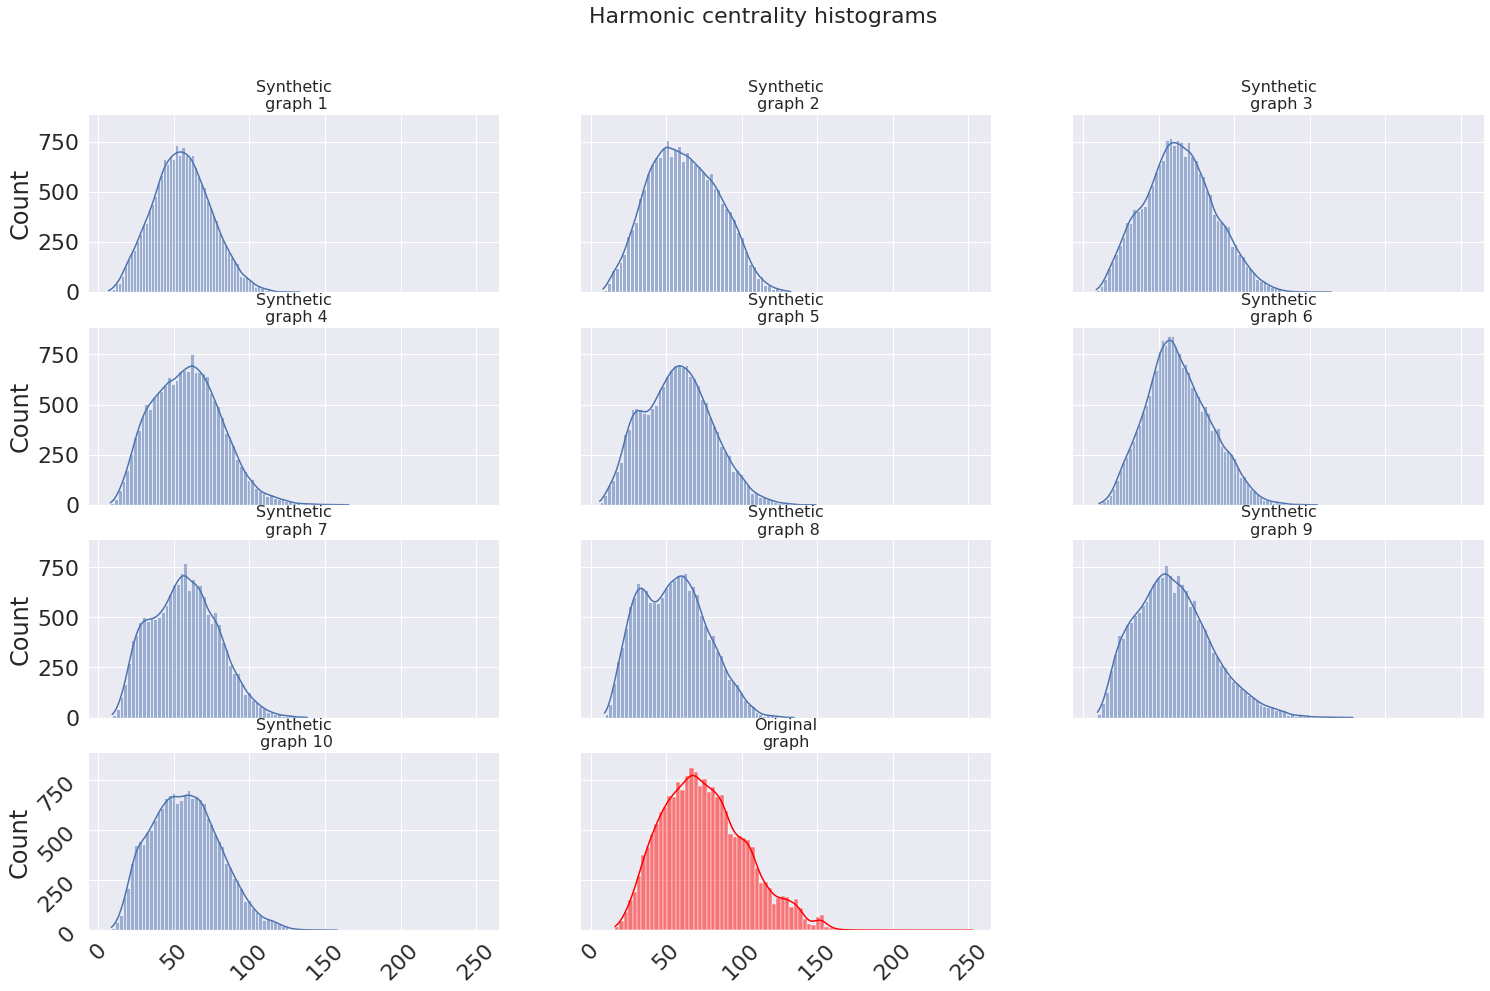

In [ ]:
stat_tests.harmonic_centrality_hist()

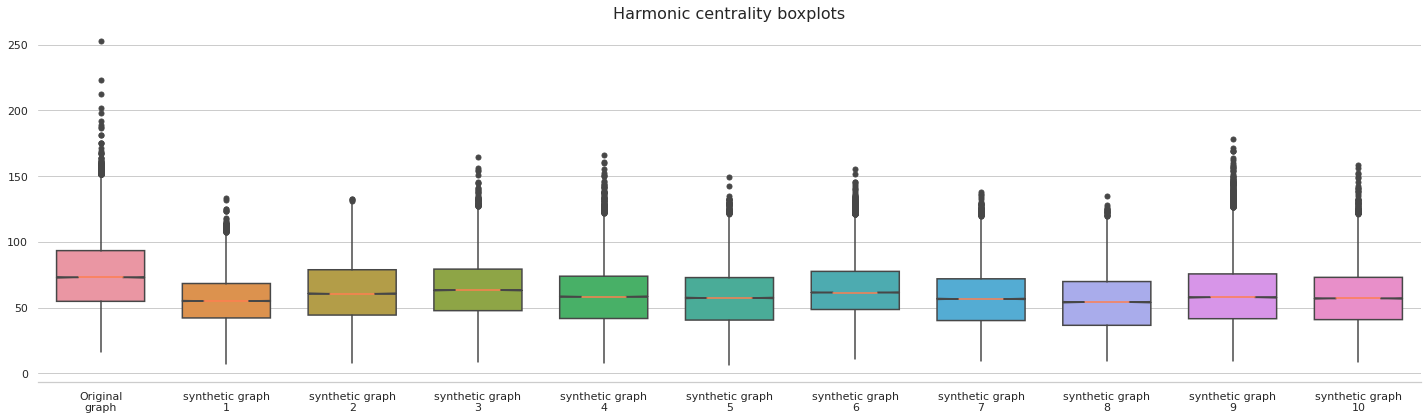

In [ ]:
stat_tests.harmonic_centrality_boxplot()

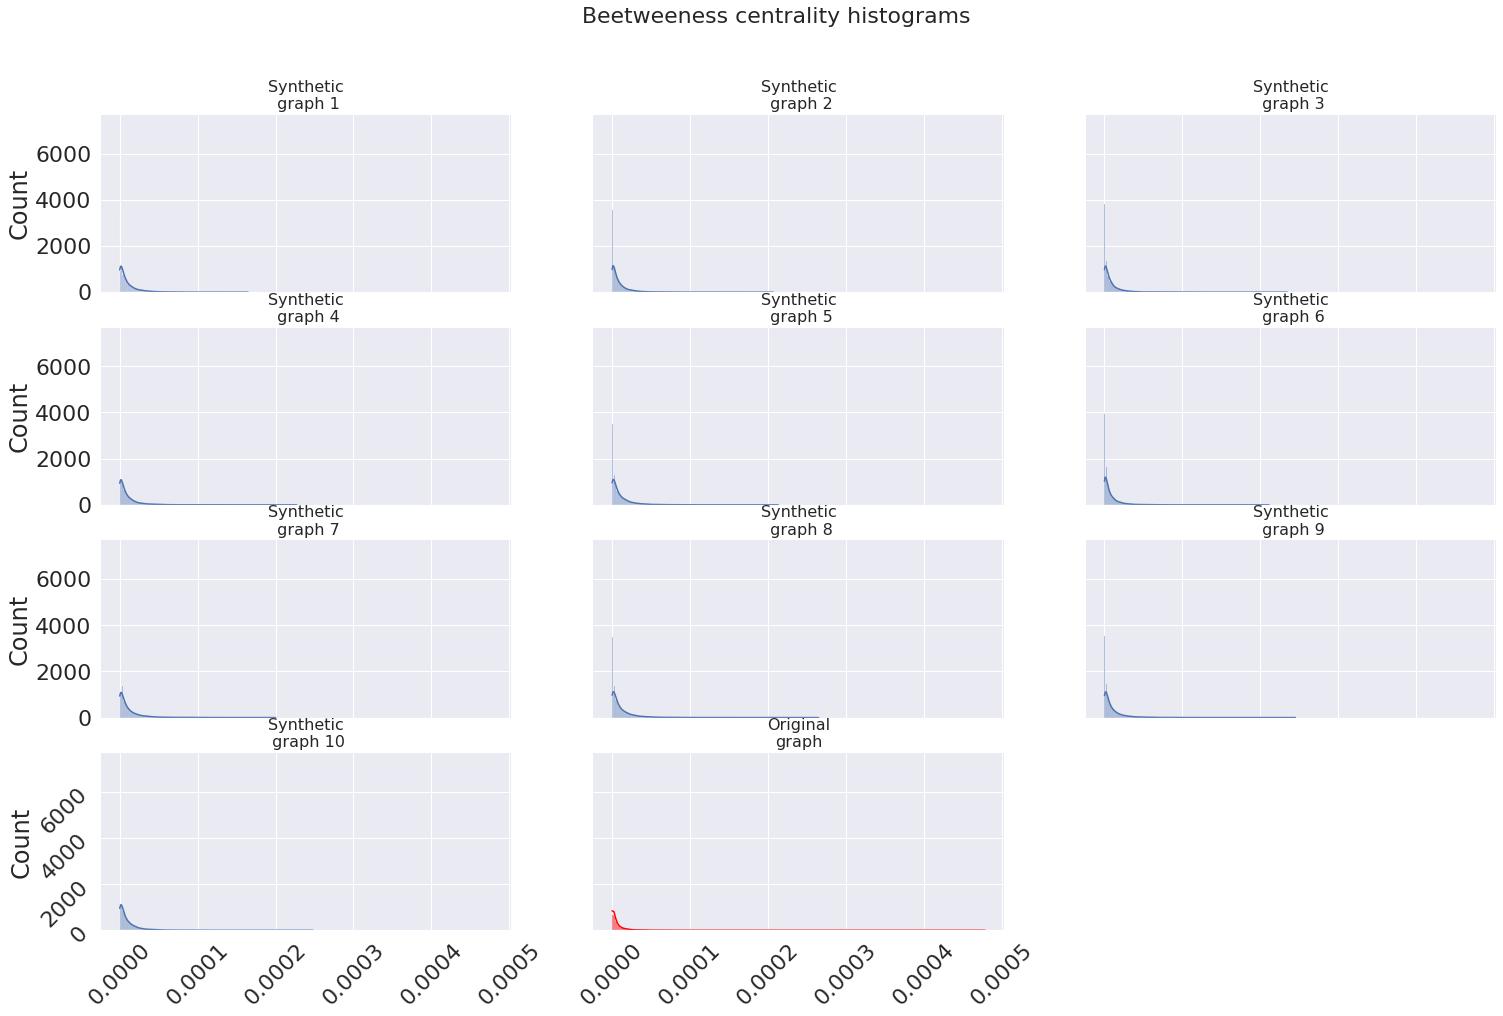

In [ ]:
stat_tests.beetweenness_centrality_hist()

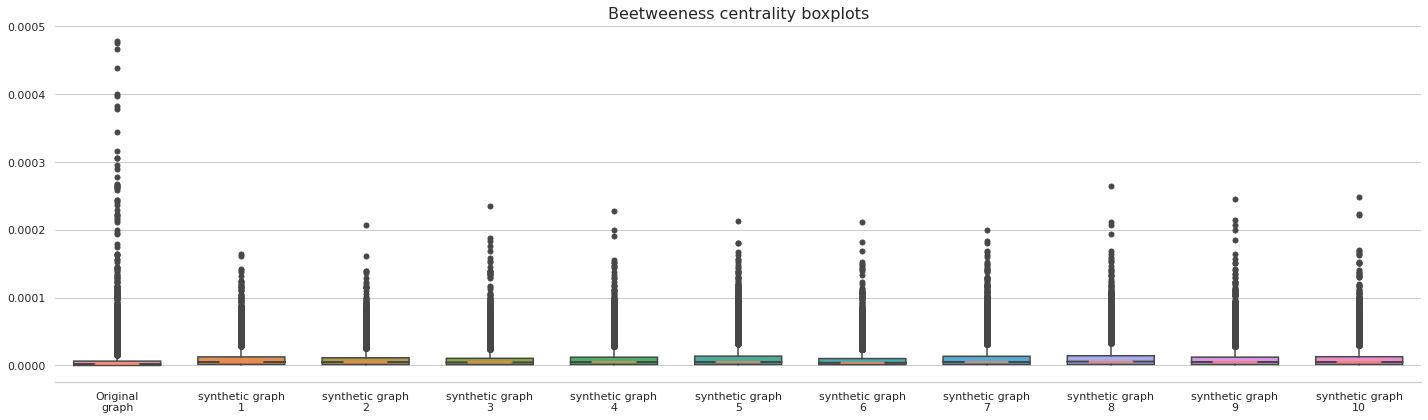

In [ ]:
stat_tests.beetweenness_centrality_boxplot()

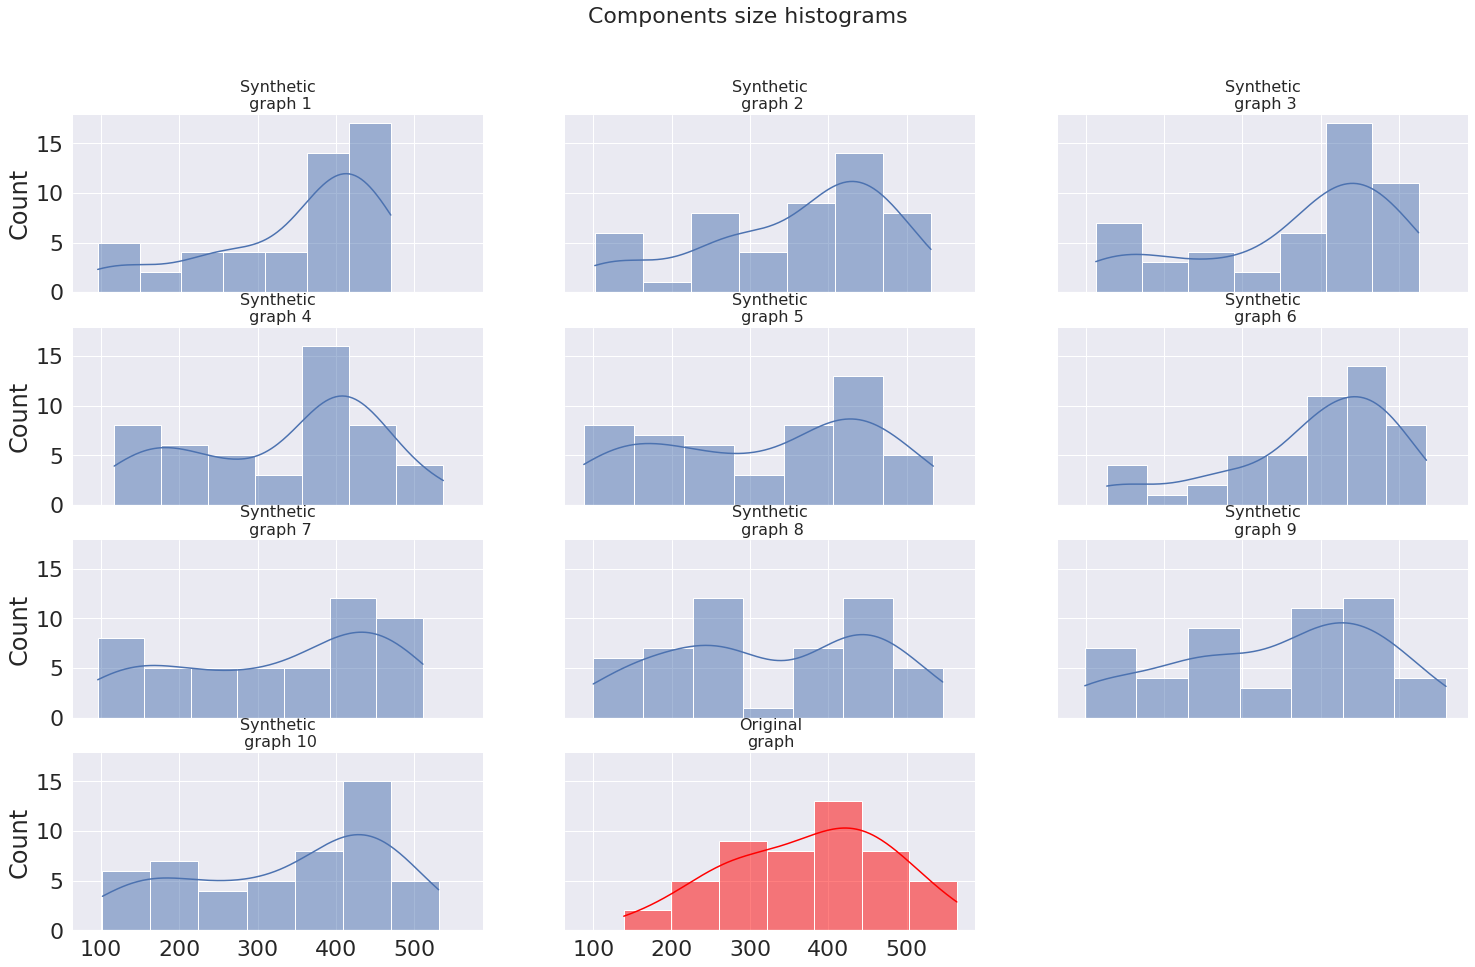

In [ ]:
stat_tests.components_sizes_hist()

## Visual similarity tests

In [ ]:
sim_test = vis_sim(orig_filename = orig_filename, graph_filename = graphs_folder,
                   emb_model = "riwalk", scale = False, dataset='cora', load_synt= True, orig_g_count = 13000, synt_g_count = 3000, batch_size = 100, label_name = 'label', ed_label=None, cut_label=False)

In [ ]:
sim_test.measure_similarity()

In [ ]:
sim_test.draw_sim_graphs(15, metric = "euc")

## Classification tests

In [ ]:
orig_graphs_folder = '/content/drive/MyDrive/Github/graphgen/datasets/cora/graphs/graph'
synt_graphs_folder = '/content/drive/MyDrive/Github/graphgen/graphs/DFScodeRNN_cora_2022-12-27 00:24:56/5180/graph'
params_graphgen_cora_synth = {'n_estimators': 1400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 43, 'class_weight': 'balanced', 'bootstrap': False}
params_graphgen_cora_synth, graphgen_cora_large_synt = class_test(20, False, orig_graphs_folder, synt_graphs_folder, batch_size= 25, dataset = 'cora', orig_g_count =  480, synt_g_count = 3200, ed_label = None, cut_label = False,
                                                                  model_params=params_graphgen_cora_synth, riwalk = True, SMOTE= False, balance = True)

In [ ]:
print(params_graphgen_cora_synth)

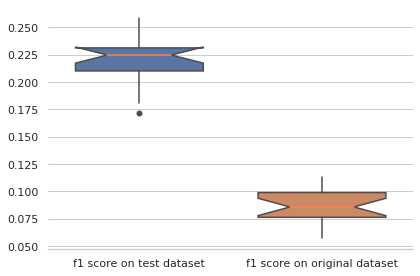

In [ ]:
draw_accuracy_boxplot(graphgen_cora_large_synt)

In [ ]:
params_graphgen_cora_orig, graphgen_cora_large_orig = class_test(10, True, orig_graphs_folder, synt_graphs_folder,batch_size= 25, dataset = 'cora', orig_g_count =  480, synt_g_count = 3200, ed_label = None, cut_label = False,
                                                                 model_params=params_graphgen_cora_synth, riwalk = True, SMOTE= False, balance = True)

In [ ]:
print(params_graphgen_cora_orig)

In [ ]:
draw_accuracy_boxplot(graphgen_cora_large_orig)

# GDSS

#   QM9 dataset

---

## Statistical tests

In [ ]:
synt_graphs_folder = '/content/drive/MyDrive/Github/GDSS/logs_sample/QM9/test/graph'
orig_graphs_folder = '/content/drive/MyDrive/Github/GDSS/QM9_graphs/graph'

stat_tests = graph_statistics(None, orig_graphs_folder , synt_graphs_folder, dataset = 'MOL', orig_graph_cnt = 13000, gen_graph_cnt = 4000, another_load_method = True)

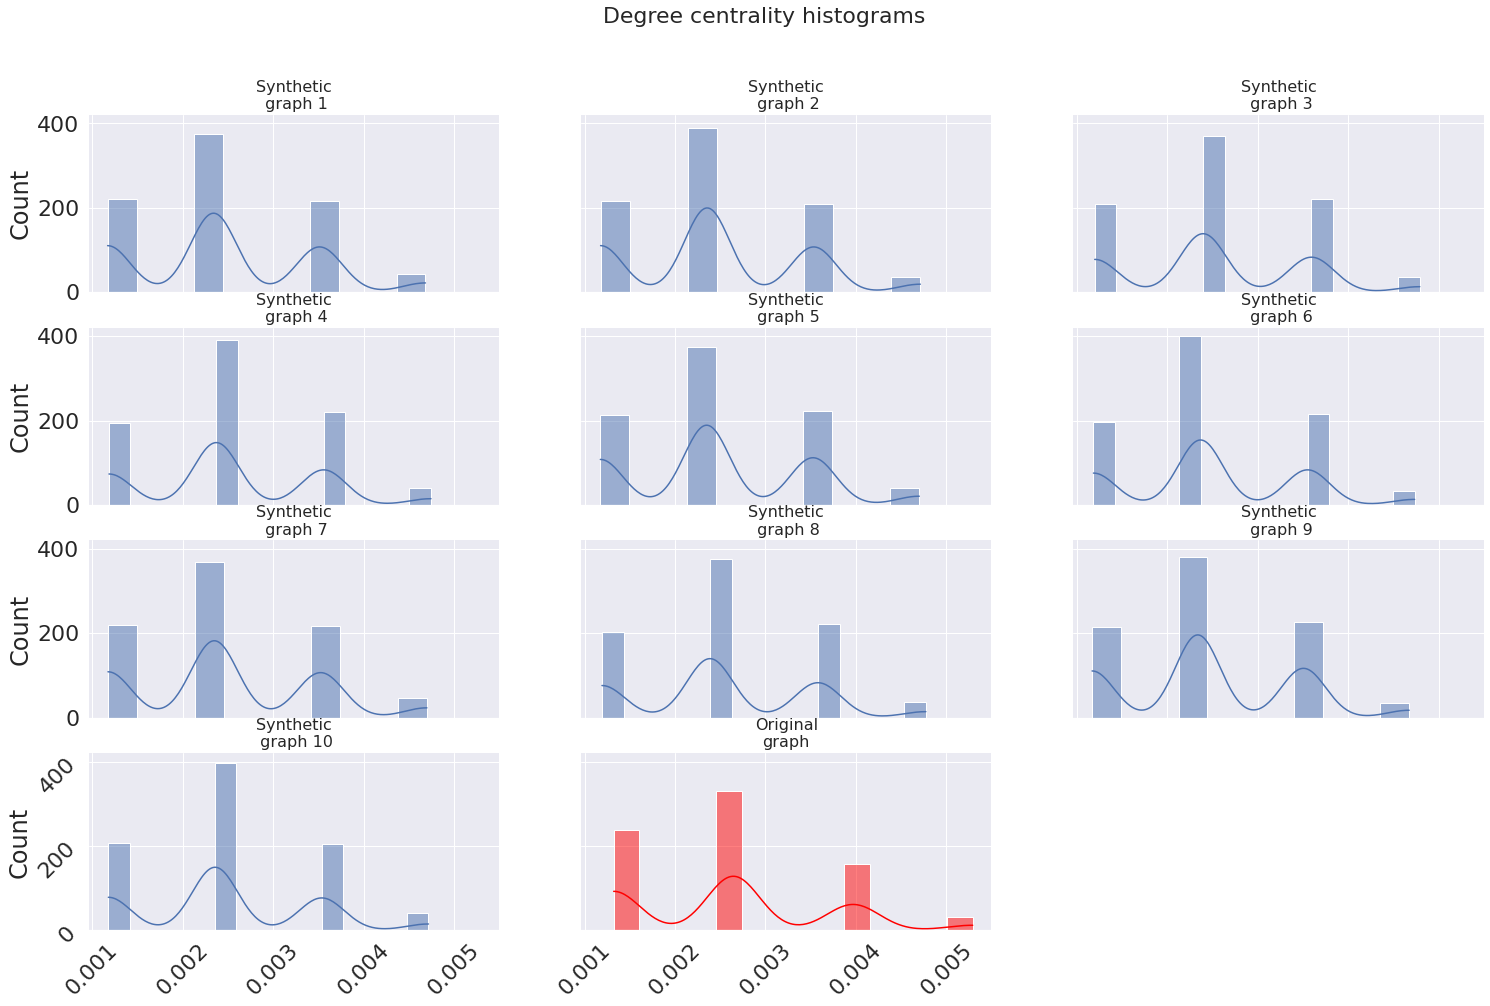

In [ ]:
stat_tests.degree_centrality_hist()

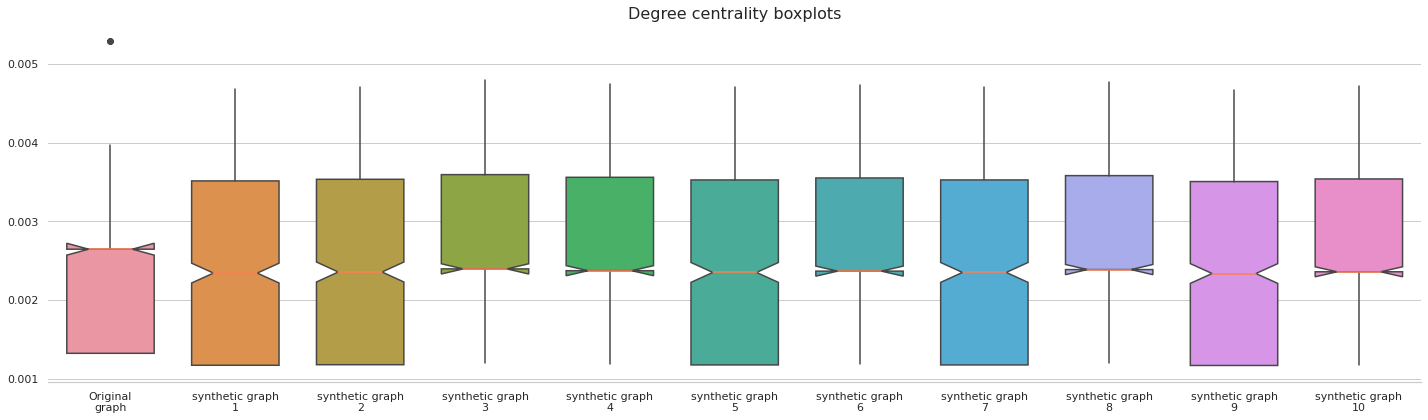

In [ ]:
stat_tests.degree_centrality_boxplot()

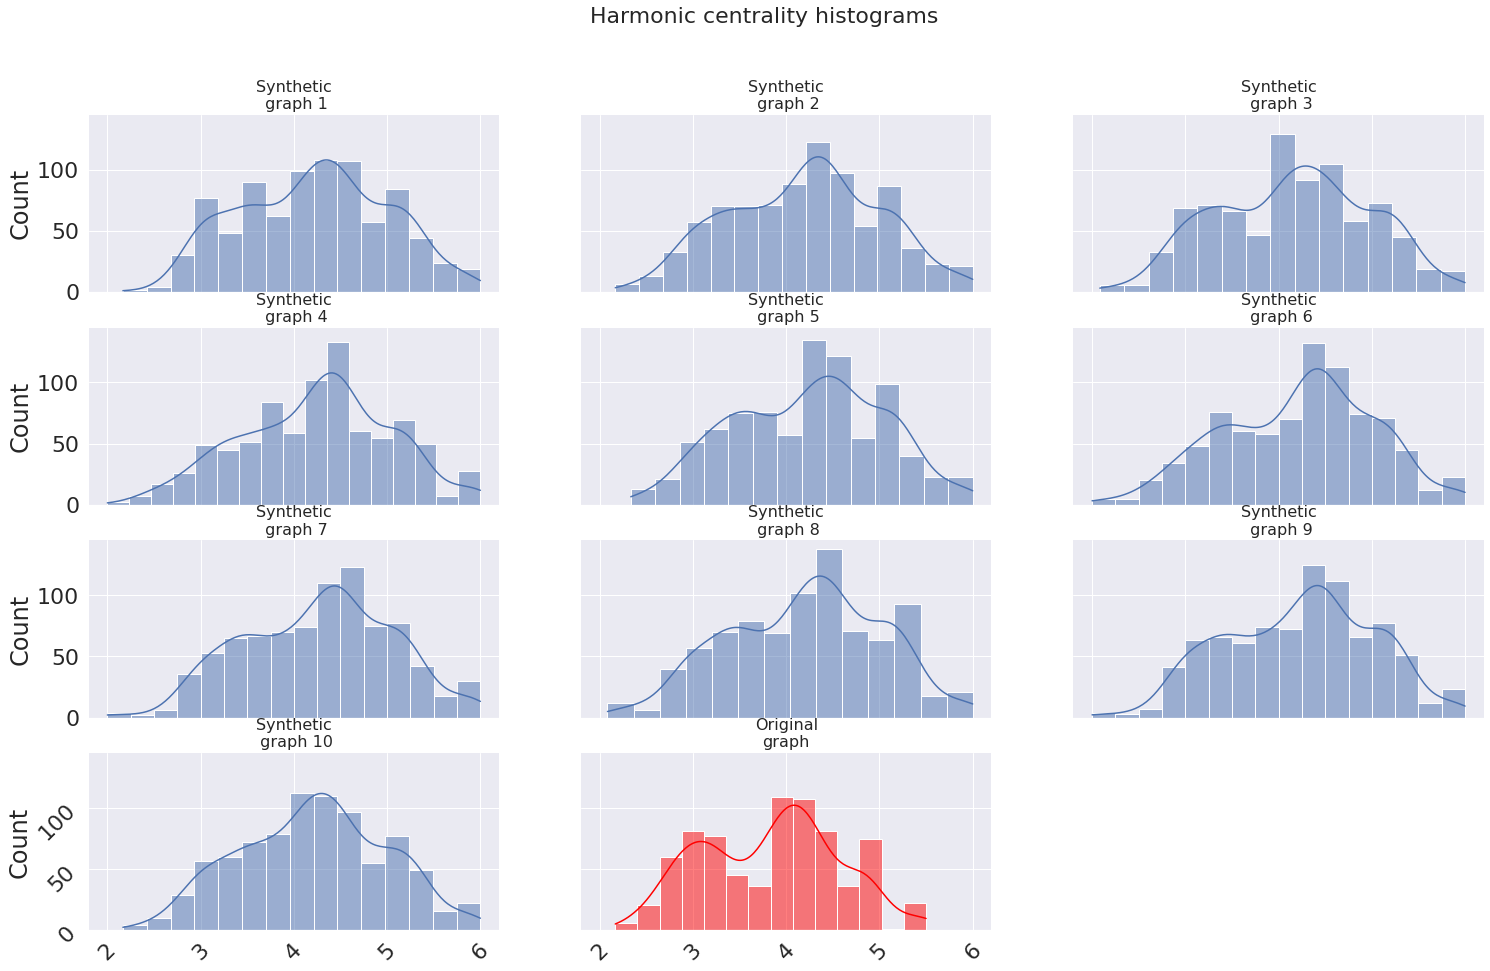

In [ ]:
stat_tests.harmonic_centrality_hist()

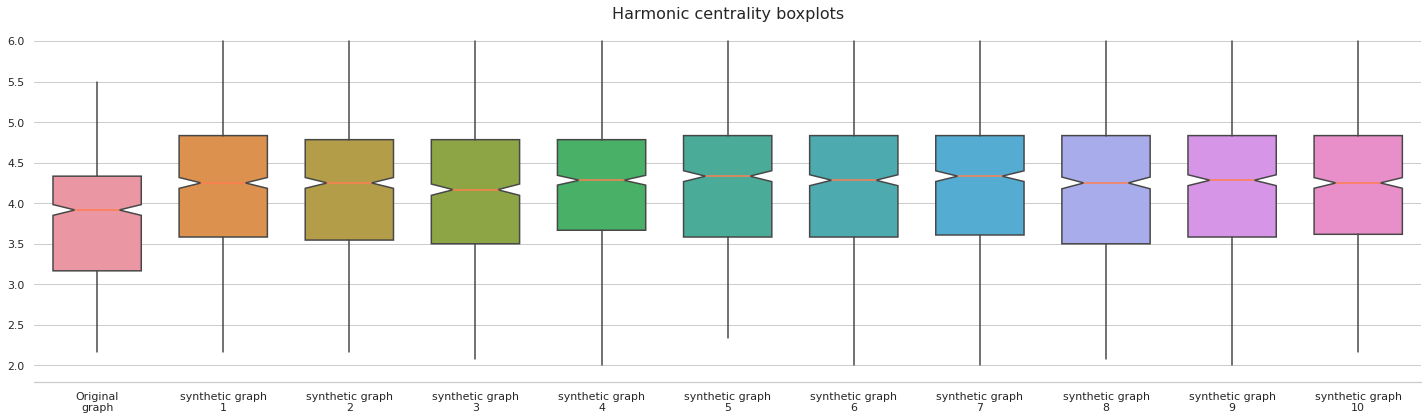

In [ ]:
stat_tests.harmonic_centrality_boxplot()

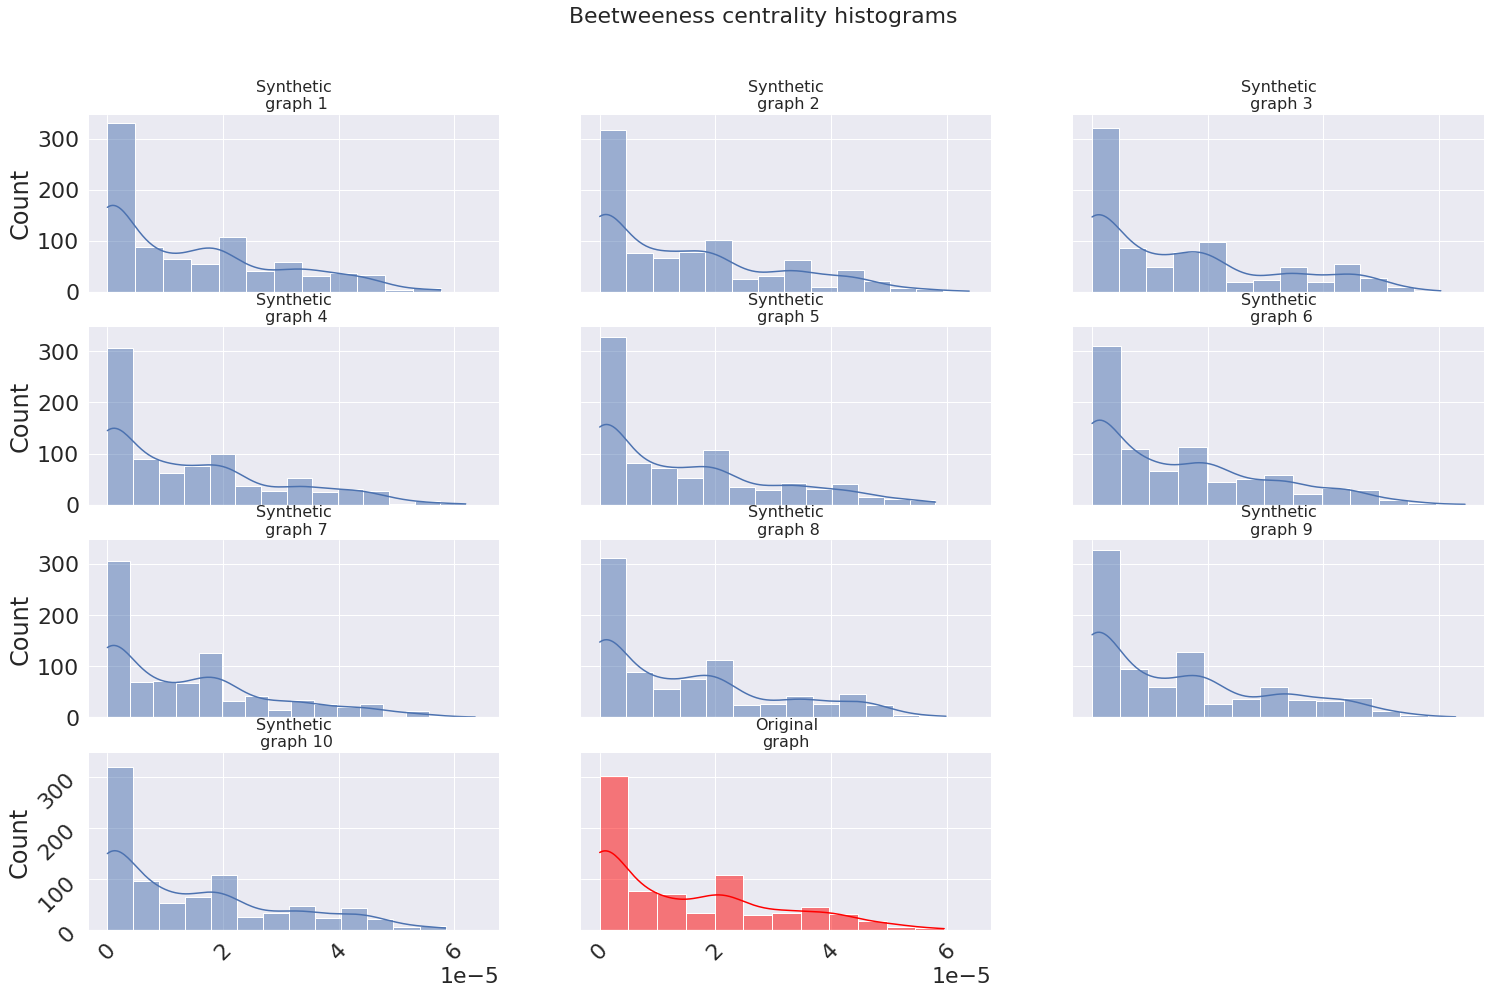

In [ ]:
stat_tests.beetweenness_centrality_hist()

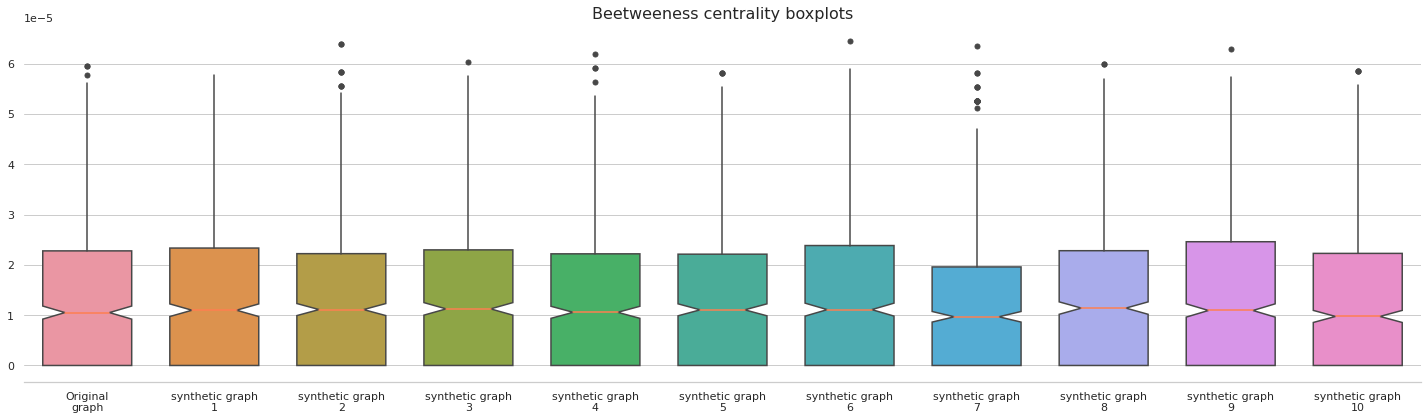

In [ ]:
stat_tests.beetweenness_centrality_boxplot()

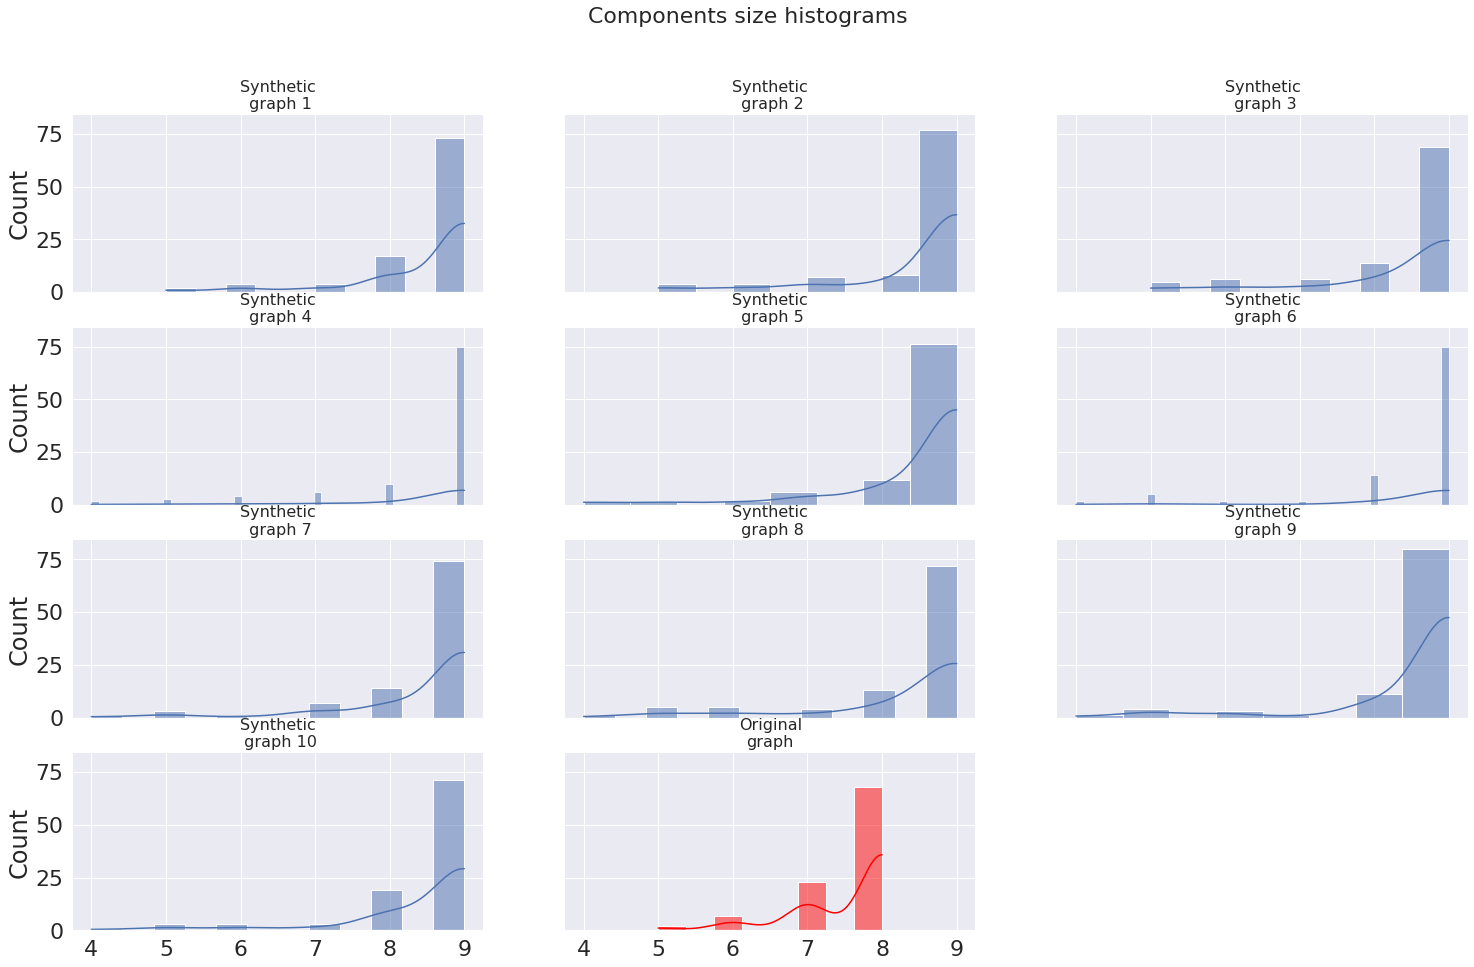

In [ ]:
stat_tests.components_sizes_hist()

## Visual similarity tests

In [ ]:
sim_test = vis_sim(orig_filename = orig_filename, graph_filename = graphs_folder,
                   emb_model = "riwalk", scale = False, dataset='MOL', load_synt= True, orig_g_count = 13000, synt_g_count = 3000, batch_size = 100, label_name = 'label', ed_label=None, cut_label=False)

In [ ]:
sim_test.measure_similarity()

In [ ]:
sim_test.draw_sim_graphs(15, metric = "euc")

## Classification tests

In [ ]:
synt_graphs_folder = '/content/drive/MyDrive/Github/GDSS/logs_sample/QM9/test/graph'
orig_graphs_folder = '/content/drive/MyDrive/Github/GDSS/QM9_graphs/graph'
params_gdss_synth = {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 76, 'class_weight': 'balanced', 'bootstrap': True}
params_gdss_synth, gdss_synt = class_test(30, False, orig_graphs_folder, synt_graphs_folder, dataset = 'MOL', orig_g_count =  570, synt_g_count = 4000,
                                          model_params=params_gdss_synth, riwalk = True, SMOTE= False, balance = True, label_name='label')

In [ ]:
print(params_gdss_synth)

{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 76, 'class_weight': 'balanced', 'bootstrap': True}


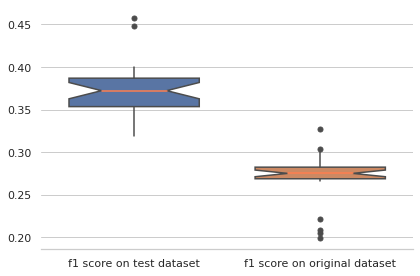

In [ ]:
draw_accuracy_boxplot(gdss_synt)

In [ ]:
params_gdss_orig, gdss_orig = class_test(10, True, orig_graphs_folder, synt_graphs_folder, dataset = 'MOL', orig_g_count =  13000, synt_g_count = 10000,
                                         model_params=params_gdss_synth, riwalk = True, SMOTE= False, balance = True)

In [ ]:
print(params_gdss_orig)

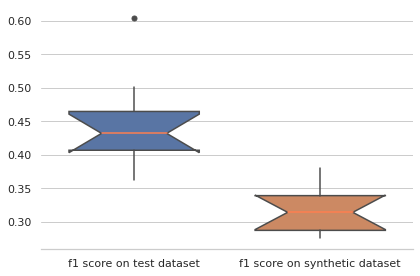

In [ ]:
draw_accuracy_boxplot(gdss_orig)